In [34]:
import os, glob
import sys
import copy 
import pydicom
import random
import re
import scipy
import scipy.misc
import numpy as np
import cv2
import imageio
import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import *
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from scipy.ndimage import rotate
from skimage import exposure
from sklearn.metrics import confusion_matrix
from operator import add 
plt.set_cmap('gray')
%matplotlib inline
seed = 42
random.seed = seed
np.random.seed = seed
tf.seed = seed


IMG_DTYPE = float
SEG_DTYPE = np.uint8

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, Activation, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.metrics import Recall, Precision


<Figure size 640x480 with 0 Axes>

In [35]:
masks_path = os.path.join('train','masks')
training_path = os.path.join('train','patients')

In [36]:
def imshow(*images, **kwargs):
    """
    Display one or more images using matplotlib.
    
    Parameters:
    - images: One or more images to be displayed.
    - cmap: Colormap to be used (default: 'gray').
    - title: Title for the image plot or a list of titles for each image.
    """
    
    num_images = len(images)
    
    if num_images == 0:
        raise ValueError("No images provided to imshow function.")
    
    cmap = kwargs.get('cmap', 'gray')
    title = kwargs.get('title', '')
    
    # Ensure cmap and title are lists of the same length as images
    if isinstance(cmap, str):
        cmap = [cmap] * num_images
    if isinstance(title, str):
        title = [title] * num_images

    plt.figure(figsize=(num_images * 5, 10))
    
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i], cmap=cmap[i], interpolation='none')
        plt.title(title[i])
        plt.axis('off')
    
    plt.show()

def normalize_image(img):
    """
    Normalize image pixel values to the range [0, 1].
    
    Parameters:
    - img: Image to be normalized.
    
    Returns:
    - Normalized image.
    """
    min_val, max_val = float(np.min(img)), float(np.max(img))
    return (img - min_val) / (max_val - min_val)

def dice(im1, im2):
    """
    Compute the Dice similarity coefficient between two binary images.
    
    Parameters:
    - im1, im2: Input binary images.
    
    Returns:
    - Dice similarity coefficient.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())


In [37]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):

        tumor_volume = None
        
        image_path = os.path.join(self.path,"patients", id_name)
        mask_path = os.path.join(self.path,"masks")
        all_masks = os.listdir(mask_path)
        dicom_image = pydicom.dcmread(image_path)
        
        image = step1_preprocess_img_slice(dicom_image.pixel_array)
       
        liver_mask_id = id_name.split('_')
        liver_mask = pydicom.dcmread(os.path.join(mask_path, liver_mask_id[0]+'_liver', id_name)).pixel_array
        
        image = np.multiply(image,np.clip(liver_mask,0,1))
        
        image = np.array(Image.fromarray(image).resize([image_size, image_size])).astype(IMG_DTYPE)
        mask = cv2.imread(os.path.join(masks_path,'merged_livertumors', id_name+'.jpg'))
        
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        retval, mask = cv2.threshold(mask, 100, 255, cv2.THRESH_BINARY)
        mask = np.array(Image.fromarray(mask).resize([image_size, image_size])).astype(IMG_DTYPE)
        mask = mask // 255
        
        mask = mask[:, :, np.newaxis]
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
#         print(files_batch)
        image = []
        mask  = []
        for id_name in files_batch:

            _img, _mask = self.__load__(id_name)
            _img = np.stack((_img,)*3, axis=-1)
            image.append(_img)
            mask.append(_mask)
        
        image = np.array(image)
        mask  = np.array(mask)

        return image, mask
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))
    


In [50]:
image_size =  256
train_path = "train"
batch_size = 10
epochs = 100
## Training Ids
images = []
for file in os.listdir(os.path.join(train_path, "patients")):

    images.append(file)


## Validation Data Size
val_data_size = len(images)//5 # 20% validation Data
# factor = 0
valid_ids = images[:val_data_size]
train_ids = images[val_data_size:]
print(len(train_ids))

18617


In [51]:
# def step1_preprocess_img_slice(img_slc):
#     """
#     Preprocesses the image 3d volumes by performing the following :
#     1- Set pixels with hounsfield value great than 1200, to zero.
#     2- Clip all hounsfield values to the range [-100, 400]
#     3- Apply Histogram Equalization
#     """    
    
#     # Set pixels with Hounsfield values greater than 1200 to zero
#     slice_data[slice_data > 1000] = 0
    
#     # Clip Hounsfield values to the range [-100, 400]
#     slice_data = np.clip(slice_data, -100, 400)
    
#     # Normalize image pixel values to [0, 1]
#     slice_data = normalize_image_values(slice_data)
    
#     # Convert normalized values to range [0, 255]
#     slice_data_uint8 = (slice_data * 255).astype('uint8')
    
#     # Apply histogram equalization
#     equalized_slice_data = cv2.equalizeHist(slice_data_uint8)
    
#     # Normalize the pixel values of equalized data
#     normalized_equalized_slice = normalize_image_values(equalized_slice_data)
    
#     return normalized_equalized_slice

def step1_preprocess_img_slice(img_slc):
    """
    Preprocesses the image 3d volumes by performing the following :
    1- Set pixels with hounsfield value great than 1200, to zero.
    2- Clip all hounsfield values to the range [-100, 400]
    3- Apply Histogram Equalization
    """    
    img_slc[img_slc>1200] = 0
    img_slc   = np.clip(img_slc, -100, 400)
    img_slc = normalize_image(img_slc)

    
    img_slc = img_slc * 255
    img_slc = img_slc.astype('uint8')
    img_slc = cv2.equalizeHist(img_slc)
    img_slc = normalize_image(img_slc)
    return img_slc


In [52]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(10)
print(x.shape,y.shape)

(10, 256, 256, 3) (10, 256, 256, 1)


0


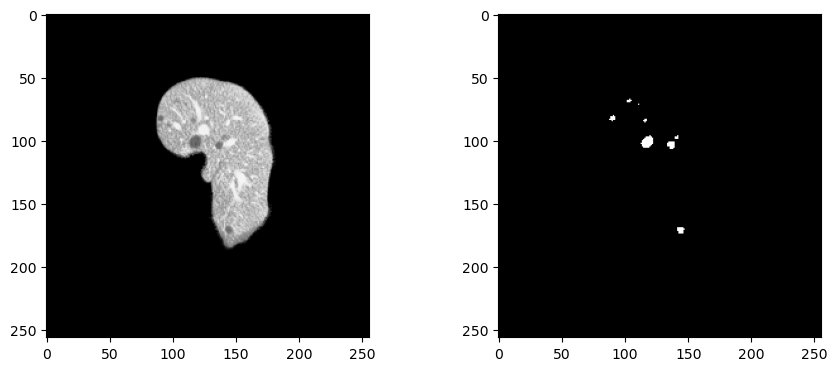

In [53]:
r = random.randint(0, len(x)-1)
r = 0
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
print(r)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

In [54]:
def convBlock(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=True):
  if transpose == False:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
  else:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)

  conv = Activation(act)(conv)
  return conv


def convBlock2(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=True):
  if transpose == False:
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)
  else:
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)

  return conv
  
'''
  Attention block/mechanism
'''
def attention_block(x, gating, inter_shape, drop_rate=0.25):
   
    # Find shape of inputs
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    ## Process x vector and gating signal
    # x vector input and processing
    theta_x = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation='softmax')(x)
    theta_x = MaxPooling2D((2,2))(theta_x)
    shape_theta_x = K.int_shape(theta_x)

    # gating signal ""
    phi_g = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation='softmax')(gating)
    shape_phi_g = K.int_shape(phi_g)

    # Add components
    concat_xg = add([phi_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    # Apply convolution
    psi = Conv2D(1, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation='softmax')(act_xg)

    # Apply sigmoid activation
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)

    # UpSample and resample to correct size
    upsample_psi = UpSampling2D(interpolation='bilinear', size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
    upsample_psi = tf.image.resize(upsample_psi, (shape_x[1], shape_x[2]))  # Resize upsample_psi
    y = multiply([upsample_psi, x])

    return y


'''
  Attention U-Net model
'''

def UNetAM(trained_weights = None, input_size = (256,256,3), drop_rate = 0.25, lr=0.00001, filter_base=16):

    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    ## Contraction phase
    conv = convBlock2(inputs, filter_base, 3)
    #conv0 = Dropout(drop_rate)(conv0)

    conv0 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv0 = convBlock2(conv0, 2 * filter_base, 3)

    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
    conv1 = convBlock2(pool0, 4 * filter_base, 3)
    #conv1 = Dropout(drop_rate)(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = convBlock2(pool1, 8 * filter_base, 3)
    #conv2 = Dropout(drop_rate)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = convBlock2(pool2, 16 * filter_base, 3)
    #conv3 = Dropout(drop_rate)(conv3)

    ## Expansion phase
    up4 = (Conv2DTranspose(8 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv3))
    merge4 = attention_block(conv2, conv3, 8 * filter_base, drop_rate) # Attention gate
    conv4 = concatenate([up4, merge4])
    conv4 = convBlock2(conv4, 8 * filter_base, 3)

    up5 = (Conv2DTranspose(4 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv4))
    merge5 = attention_block(conv1, conv4, 4 * filter_base, drop_rate) # Attention gate
    conv5 = concatenate([up5, merge5])
    conv5 = convBlock2(conv5, 4 * filter_base, 3)

    up6 = (Conv2DTranspose(2 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = attention_block(conv0, conv5, 2 * filter_base, drop_rate) # Attention gate
    conv6 = concatenate([up6, merge6])
    conv6 = convBlock2(conv6, 2 * filter_base, 3)

    up7 = (Conv2DTranspose(1 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = attention_block(conv, conv6, 1 * filter_base, drop_rate) # Attention gate
    conv7 = concatenate([up7, merge7])
    conv7 = concatenate([up7, conv])
    conv7 = convBlock2(conv7, 1 * filter_base, 3)

    ## Output layer
    out = convBlock(conv7, 1, 1, act='sigmoid')

    model = Model(inputs, out)

#     model.compile(optimizer = adam_v2.Adam(learning_rate = lr), loss = binary_crossentropy, metrics = ['accuracy', 'mse'])

    if trained_weights != None:
      model.load_weights(trained_weights)

    return model

In [55]:
'''
  Convolutional block with two conv layers and two activation layers
'''
import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import *

def convBlock(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=True):
  if transpose == False:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
  else:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)

  conv = Activation(act)(conv)
  return conv


def convBlock2(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=True):
  if transpose == False:
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)
  else:
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)

  return conv
  
'''
  Attention block/mechanism
'''
def attention_block(x, gating, inter_shape, drop_rate=0.25):
   
    # Find shape of inputs
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    ## Process x vector and gating signal
    # x vector input and processing
    theta_x = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation='softmax')(x)
    theta_x = MaxPooling2D((2,2))(theta_x)
    shape_theta_x = K.int_shape(theta_x)

    # gating signal ""
    phi_g = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation='softmax')(gating)
    shape_phi_g = K.int_shape(phi_g)

    # Add components
    concat_xg = add([phi_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    # Apply convolution
    psi = Conv2D(1, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation='softmax')(act_xg)

    # Apply sigmoid activation
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)

    # UpSample and resample to correct size
    upsample_psi = UpSampling2D(interpolation='bilinear', size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
    upsample_psi = tf.image.resize(upsample_psi, (shape_x[1], shape_x[2]))  # Resize upsample_psi
    y = multiply([upsample_psi, x])

    return y


'''
  Attention U-Net model
'''

def UNetAM(trained_weights = None, input_size = (256,256,3), drop_rate = 0.25, lr=0.0001, filter_base=16):

    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    ## Contraction phase
    conv = convBlock2(inputs, filter_base, 3)
    #conv0 = Dropout(drop_rate)(conv0)

    conv0 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv0 = convBlock2(conv0, 2 * filter_base, 3)

    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
    conv1 = convBlock2(pool0, 4 * filter_base, 3)
    #conv1 = Dropout(drop_rate)(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = convBlock2(pool1, 8 * filter_base, 3)
    #conv2 = Dropout(drop_rate)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = convBlock2(pool2, 16 * filter_base, 3)
    #conv3 = Dropout(drop_rate)(conv3)

    ## Expansion phase
    up4 = (Conv2DTranspose(8 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv3))
    merge4 = attention_block(conv2, conv3, 8 * filter_base, drop_rate) # Attention gate
    conv4 = concatenate([up4, merge4])
    conv4 = convBlock2(conv4, 8 * filter_base, 3)

    up5 = (Conv2DTranspose(4 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv4))
    merge5 = attention_block(conv1, conv4, 4 * filter_base, drop_rate) # Attention gate
    conv5 = concatenate([up5, merge5])
    conv5 = convBlock2(conv5, 4 * filter_base, 3)

    up6 = (Conv2DTranspose(2 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = attention_block(conv0, conv5, 2 * filter_base, drop_rate) # Attention gate
    conv6 = concatenate([up6, merge6])
    conv6 = convBlock2(conv6, 2 * filter_base, 3)

    up7 = (Conv2DTranspose(1 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = attention_block(conv, conv6, 1 * filter_base, drop_rate) # Attention gate
    conv7 = concatenate([up7, merge7])
    conv7 = concatenate([up7, conv])
    conv7 = convBlock2(conv7, 1 * filter_base, 3)

    ## Output layer
    out = convBlock(conv7, 1, 1, act='sigmoid')

    model = Model(inputs, out)

#     model.compile(optimizer = adam_v2.Adam(learning_rate = lr), loss = binary_crossentropy, metrics = ['accuracy', 'mse'])

    if trained_weights != None:
      model.load_weights(trained_weights)

    return model

In [56]:
smooth = 1e-15

def dice_coef(y_true, y_pred):
    y_true_f = keras.layers.Flatten()(y_true)
    y_pred_f = y_true_f = keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def iou(y_true,y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [57]:
model = UNetAM()
# model = UNet()
# model = attention_resunet(16)
adam = tf.keras.optimizers.legacy.Adam()
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=["acc", dice_coef, iou, Recall(), Precision()])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(1, 256, 256, 3)]           0         []                            
                                                                                                  
 conv2d_transpose_65 (Conv2  (1, 256, 256, 16)            448       ['input_6[0][0]']             
 DTranspose)                                                                                      
                                                                                                  
 activation_90 (Activation)  (1, 256, 256, 16)            0         ['conv2d_transpose_65[0][0]'] 
                                                                                                  
 conv2d_transpose_66 (Conv2  (1, 256, 256, 16)            2320      ['activation_90[0][0]'] 

 )                                                                                                
                                                                                                  
 up_sampling2d_12 (UpSampli  (1, 32, 32, 1)               0         ['activation_101[0][0]']      
 ng2D)                                                                                            
                                                                                                  
 tf.image.resize_4 (TFOpLam  (1, 32, 32, 1)               0         ['up_sampling2d_12[0][0]']    
 bda)                                                                                             
                                                                                                  
 conv2d_transpose_75 (Conv2  (1, 32, 32, 128)             131200    ['activation_99[0][0]']       
 DTranspose)                                                                                      
          

                                                                                                  
 activation_108 (Activation  (1, 64, 64, 32)              0         ['add_32[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_91 (Conv2D)          (1, 64, 64, 1)               33        ['activation_108[0][0]']      
                                                                                                  
 activation_109 (Activation  (1, 64, 64, 1)               0         ['conv2d_91[0][0]']           
 )                                                                                                
                                                                                                  
 up_sampling2d_14 (UpSampli  (1, 128, 128, 1)             0         ['activation_109[0][0]']      
 ng2D)    

In [58]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)
# test_gen  = DataGenTest(train_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size


logger_path = os.path.join("Liver-tumor-segmentation-unet-attention.csv")
path_ = "Dataset"

callbacks = [
    ModelCheckpoint(path_, verbose=1, save_best_only=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=10, min_lr=1e-7,verbose=1),
    CSVLogger(logger_path),
    TensorBoard(),
    EarlyStopping(monitor='val_loss',patience=50,restore_best_weights=False)
]

model_history = model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs, shuffle=True, callbacks=callbacks)

Epoch 1/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0232 - acc: 0.9927 - dice_coef: 0.2269 - iou: 0.1420 - recall_3: 0.1591 - precision_3: 0.5923
Epoch 1: val_loss improved from inf to 0.01597, saving model to Dataset
INFO:tensorflow:Assets written to: Dataset/assets


INFO:tensorflow:Assets written to: Dataset/assets


1861/1861 [==============================] - 1521s 817ms/step - loss: 0.0232 - acc: 0.9927 - dice_coef: 0.2269 - iou: 0.1420 - recall_3: 0.1591 - precision_3: 0.5923 - val_loss: 0.0160 - val_acc: 0.9949 - val_dice_coef: 0.4091 - val_iou: 0.2675 - val_recall_3: 0.4152 - val_precision_3: 0.8095 - lr: 0.0010
Epoch 2/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0103 - acc: 0.9964 - dice_coef: 0.5850 - iou: 0.4321 - recall_3: 0.6897 - precision_3: 0.8110
Epoch 2: val_loss improved from 0.01597 to 0.00792, saving model to Dataset
INFO:tensorflow:Assets written to: Dataset/assets


INFO:tensorflow:Assets written to: Dataset/assets


1861/1861 [==============================] - 850s 457ms/step - loss: 0.0103 - acc: 0.9964 - dice_coef: 0.5850 - iou: 0.4321 - recall_3: 0.6897 - precision_3: 0.8110 - val_loss: 0.0079 - val_acc: 0.9974 - val_dice_coef: 0.6297 - val_iou: 0.4985 - val_recall_3: 0.7112 - val_precision_3: 0.9228 - lr: 0.0010
Epoch 3/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0076 - acc: 0.9973 - dice_coef: 0.6664 - iou: 0.5214 - recall_3: 0.7745 - precision_3: 0.8618
Epoch 3: val_loss improved from 0.00792 to 0.00600, saving model to Dataset
INFO:tensorflow:Assets written to: Dataset/assets


INFO:tensorflow:Assets written to: Dataset/assets


1861/1861 [==============================] - 766s 412ms/step - loss: 0.0076 - acc: 0.9973 - dice_coef: 0.6664 - iou: 0.5214 - recall_3: 0.7745 - precision_3: 0.8618 - val_loss: 0.0060 - val_acc: 0.9979 - val_dice_coef: 0.6856 - val_iou: 0.5615 - val_recall_3: 0.8095 - val_precision_3: 0.8965 - lr: 0.0010
Epoch 4/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0067 - acc: 0.9976 - dice_coef: 0.6959 - iou: 0.5559 - recall_3: 0.7914 - precision_3: 0.8794
Epoch 4: val_loss did not improve from 0.00600
1861/1861 [==============================] - 765s 411ms/step - loss: 0.0067 - acc: 0.9976 - dice_coef: 0.6959 - iou: 0.5559 - recall_3: 0.7914 - precision_3: 0.8794 - val_loss: 0.0155 - val_acc: 0.9945 - val_dice_coef: 0.4345 - val_iou: 0.2672 - val_recall_3: 0.3179 - val_precision_3: 0.8723 - lr: 0.0010
Epoch 5/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0072 - acc: 0.9974 - dice_coef: 0.6777 - iou: 0.5385 - recall_3: 0.7788 - precision_3: 0.8714
Epo

INFO:tensorflow:Assets written to: Dataset/assets


1861/1861 [==============================] - 311s 167ms/step - loss: 0.0081 - acc: 0.9971 - dice_coef: 0.4625 - iou: 0.3472 - recall_3: 0.7508 - precision_3: 0.8620 - val_loss: 0.0059 - val_acc: 0.9980 - val_dice_coef: 0.7524 - val_iou: 0.6089 - val_recall_3: 0.8236 - val_precision_3: 0.8966 - lr: 0.0010
Epoch 9/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0077 - acc: 0.9972 - dice_coef: 0.4515 - iou: 0.3354 - recall_3: 0.7569 - precision_3: 0.8547
Epoch 9: val_loss did not improve from 0.00586
1861/1861 [==============================] - 309s 166ms/step - loss: 0.0077 - acc: 0.9972 - dice_coef: 0.4515 - iou: 0.3354 - recall_3: 0.7569 - precision_3: 0.8547 - val_loss: 0.0084 - val_acc: 0.9969 - val_dice_coef: 0.6393 - val_iou: 0.4795 - val_recall_3: 0.6863 - val_precision_3: 0.8723 - lr: 0.0010
Epoch 10/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0081 - acc: 0.9971 - dice_coef: 0.4539 - iou: 0.3258 - recall_3: 0.7452 - precision_3: 0.8329
Ep

INFO:tensorflow:Assets written to: Dataset/assets


1861/1861 [==============================] - 309s 166ms/step - loss: 0.0067 - acc: 0.9976 - dice_coef: 0.4982 - iou: 0.3787 - recall_3: 0.8131 - precision_3: 0.8722 - val_loss: 0.0057 - val_acc: 0.9979 - val_dice_coef: 0.7288 - val_iou: 0.5911 - val_recall_3: 0.8491 - val_precision_3: 0.8724 - lr: 0.0010
Epoch 14/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0066 - acc: 0.9976 - dice_coef: 0.4881 - iou: 0.3678 - recall_3: 0.8016 - precision_3: 0.8694
Epoch 14: val_loss did not improve from 0.00571
1861/1861 [==============================] - 307s 165ms/step - loss: 0.0066 - acc: 0.9976 - dice_coef: 0.4881 - iou: 0.3678 - recall_3: 0.8016 - precision_3: 0.8694 - val_loss: 0.0074 - val_acc: 0.9973 - val_dice_coef: 0.5889 - val_iou: 0.4780 - val_recall_3: 0.6959 - val_precision_3: 0.9324 - lr: 0.0010
Epoch 15/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0068 - acc: 0.9976 - dice_coef: 0.4989 - iou: 0.3795 - recall_3: 0.8092 - precision_3: 0.8681


INFO:tensorflow:Assets written to: Dataset/assets


1861/1861 [==============================] - 310s 167ms/step - loss: 0.0056 - acc: 0.9980 - dice_coef: 0.5242 - iou: 0.4058 - recall_3: 0.8356 - precision_3: 0.8880 - val_loss: 0.0053 - val_acc: 0.9981 - val_dice_coef: 0.7502 - val_iou: 0.6224 - val_recall_3: 0.8144 - val_precision_3: 0.9268 - lr: 0.0010
Epoch 22/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0055 - acc: 0.9980 - dice_coef: 0.5177 - iou: 0.4072 - recall_3: 0.8410 - precision_3: 0.8897
Epoch 22: val_loss did not improve from 0.00535
1861/1861 [==============================] - 305s 164ms/step - loss: 0.0055 - acc: 0.9980 - dice_coef: 0.5177 - iou: 0.4072 - recall_3: 0.8410 - precision_3: 0.8897 - val_loss: 0.0054 - val_acc: 0.9980 - val_dice_coef: 0.7624 - val_iou: 0.6174 - val_recall_3: 0.8882 - val_precision_3: 0.8547 - lr: 0.0010
Epoch 23/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0054 - acc: 0.9980 - dice_coef: 0.5321 - iou: 0.4196 - recall_3: 0.8493 - precision_3: 0.8923


INFO:tensorflow:Assets written to: Dataset/assets


1861/1861 [==============================] - 308s 166ms/step - loss: 0.0054 - acc: 0.9980 - dice_coef: 0.5321 - iou: 0.4196 - recall_3: 0.8493 - precision_3: 0.8923 - val_loss: 0.0048 - val_acc: 0.9983 - val_dice_coef: 0.7445 - val_iou: 0.6305 - val_recall_3: 0.8378 - val_precision_3: 0.9256 - lr: 0.0010
Epoch 24/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0057 - acc: 0.9980 - dice_coef: 0.5401 - iou: 0.4295 - recall_3: 0.8513 - precision_3: 0.8969
Epoch 24: val_loss improved from 0.00478 to 0.00475, saving model to Dataset
INFO:tensorflow:Assets written to: Dataset/assets


INFO:tensorflow:Assets written to: Dataset/assets


1861/1861 [==============================] - 308s 166ms/step - loss: 0.0057 - acc: 0.9980 - dice_coef: 0.5401 - iou: 0.4295 - recall_3: 0.8513 - precision_3: 0.8969 - val_loss: 0.0047 - val_acc: 0.9983 - val_dice_coef: 0.7833 - val_iou: 0.6579 - val_recall_3: 0.8428 - val_precision_3: 0.9273 - lr: 0.0010
Epoch 25/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0052 - acc: 0.9981 - dice_coef: 0.5431 - iou: 0.4309 - recall_3: 0.8564 - precision_3: 0.9005
Epoch 25: val_loss did not improve from 0.00475
1861/1861 [==============================] - 307s 165ms/step - loss: 0.0052 - acc: 0.9981 - dice_coef: 0.5431 - iou: 0.4309 - recall_3: 0.8564 - precision_3: 0.9005 - val_loss: 0.0097 - val_acc: 0.9973 - val_dice_coef: 0.7749 - val_iou: 0.5656 - val_recall_3: 0.6986 - val_precision_3: 0.9249 - lr: 0.0010
Epoch 26/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0051 - acc: 0.9982 - dice_coef: 0.5341 - iou: 0.4228 - recall_3: 0.8578 - precision_3: 0.8999


INFO:tensorflow:Assets written to: Dataset/assets


1861/1861 [==============================] - 311s 167ms/step - loss: 0.0052 - acc: 0.9982 - dice_coef: 0.5383 - iou: 0.4259 - recall_3: 0.8510 - precision_3: 0.8939 - val_loss: 0.0046 - val_acc: 0.9983 - val_dice_coef: 0.7859 - val_iou: 0.6610 - val_recall_3: 0.8674 - val_precision_3: 0.9091 - lr: 0.0010
Epoch 29/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0046 - acc: 0.9983 - dice_coef: 0.5480 - iou: 0.4423 - recall_3: 0.8729 - precision_3: 0.9093
Epoch 29: val_loss did not improve from 0.00462
1861/1861 [==============================] - 308s 166ms/step - loss: 0.0046 - acc: 0.9983 - dice_coef: 0.5480 - iou: 0.4423 - recall_3: 0.8729 - precision_3: 0.9093 - val_loss: 0.0049 - val_acc: 0.9982 - val_dice_coef: 0.7550 - val_iou: 0.6317 - val_recall_3: 0.8557 - val_precision_3: 0.9054 - lr: 0.0010
Epoch 30/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0050 - acc: 0.9982 - dice_coef: 0.5392 - iou: 0.4300 - recall_3: 0.8604 - precision_3: 0.9012


INFO:tensorflow:Assets written to: Dataset/assets


1861/1861 [==============================] - 311s 167ms/step - loss: 0.0049 - acc: 0.9982 - dice_coef: 0.5538 - iou: 0.4424 - recall_3: 0.8636 - precision_3: 0.9000 - val_loss: 0.0045 - val_acc: 0.9984 - val_dice_coef: 0.8123 - val_iou: 0.6836 - val_recall_3: 0.8600 - val_precision_3: 0.9257 - lr: 0.0010
Epoch 32/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0049 - acc: 0.9983 - dice_coef: 0.5432 - iou: 0.4321 - recall_3: 0.8599 - precision_3: 0.9008
Epoch 32: val_loss did not improve from 0.00454
1861/1861 [==============================] - 306s 164ms/step - loss: 0.0049 - acc: 0.9983 - dice_coef: 0.5432 - iou: 0.4321 - recall_3: 0.8599 - precision_3: 0.9008 - val_loss: 0.0049 - val_acc: 0.9982 - val_dice_coef: 0.7708 - val_iou: 0.6359 - val_recall_3: 0.9086 - val_precision_3: 0.8582 - lr: 0.0010
Epoch 33/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0048 - acc: 0.9982 - dice_coef: 0.5490 - iou: 0.4366 - recall_3: 0.8606 - precision_3: 0.8999


INFO:tensorflow:Assets written to: Dataset/assets


1861/1861 [==============================] - 311s 167ms/step - loss: 0.0048 - acc: 0.9982 - dice_coef: 0.5490 - iou: 0.4366 - recall_3: 0.8606 - precision_3: 0.8999 - val_loss: 0.0044 - val_acc: 0.9984 - val_dice_coef: 0.7783 - val_iou: 0.6617 - val_recall_3: 0.8704 - val_precision_3: 0.9165 - lr: 0.0010
Epoch 34/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0046 - acc: 0.9983 - dice_coef: 0.5562 - iou: 0.4451 - recall_3: 0.8688 - precision_3: 0.9108
Epoch 34: val_loss did not improve from 0.00441
1861/1861 [==============================] - 307s 165ms/step - loss: 0.0046 - acc: 0.9983 - dice_coef: 0.5562 - iou: 0.4451 - recall_3: 0.8688 - precision_3: 0.9108 - val_loss: 0.0046 - val_acc: 0.9983 - val_dice_coef: 0.7897 - val_iou: 0.6599 - val_recall_3: 0.8976 - val_precision_3: 0.8832 - lr: 0.0010
Epoch 35/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0050 - acc: 0.9982 - dice_coef: 0.5324 - iou: 0.4235 - recall_3: 0.8610 - precision_3: 0.9012


INFO:tensorflow:Assets written to: Dataset/assets


1861/1861 [==============================] - 309s 166ms/step - loss: 0.0044 - acc: 0.9984 - dice_coef: 0.5419 - iou: 0.4369 - recall_3: 0.8742 - precision_3: 0.9150 - val_loss: 0.0043 - val_acc: 0.9984 - val_dice_coef: 0.7660 - val_iou: 0.6571 - val_recall_3: 0.8541 - val_precision_3: 0.9339 - lr: 0.0010
Epoch 38/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0045 - acc: 0.9984 - dice_coef: 0.5483 - iou: 0.4410 - recall_3: 0.8698 - precision_3: 0.9085
Epoch 38: val_loss improved from 0.00434 to 0.00425, saving model to Dataset
INFO:tensorflow:Assets written to: Dataset/assets


INFO:tensorflow:Assets written to: Dataset/assets


1861/1861 [==============================] - 311s 167ms/step - loss: 0.0045 - acc: 0.9984 - dice_coef: 0.5483 - iou: 0.4410 - recall_3: 0.8698 - precision_3: 0.9085 - val_loss: 0.0042 - val_acc: 0.9985 - val_dice_coef: 0.8138 - val_iou: 0.6911 - val_recall_3: 0.8748 - val_precision_3: 0.9215 - lr: 0.0010
Epoch 39/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0048 - acc: 0.9983 - dice_coef: 0.5359 - iou: 0.4282 - recall_3: 0.8606 - precision_3: 0.9045
Epoch 39: val_loss did not improve from 0.00425
1861/1861 [==============================] - 307s 165ms/step - loss: 0.0048 - acc: 0.9983 - dice_coef: 0.5359 - iou: 0.4282 - recall_3: 0.8606 - precision_3: 0.9045 - val_loss: 0.0047 - val_acc: 0.9984 - val_dice_coef: 0.7936 - val_iou: 0.6672 - val_recall_3: 0.8383 - val_precision_3: 0.9429 - lr: 0.0010
Epoch 40/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0044 - acc: 0.9984 - dice_coef: 0.5635 - iou: 0.4519 - recall_3: 0.8721 - precision_3: 0.9105


INFO:tensorflow:Assets written to: Dataset/assets


1861/1861 [==============================] - 307s 165ms/step - loss: 0.0044 - acc: 0.9984 - dice_coef: 0.5635 - iou: 0.4519 - recall_3: 0.8721 - precision_3: 0.9105 - val_loss: 0.0042 - val_acc: 0.9985 - val_dice_coef: 0.7870 - val_iou: 0.6688 - val_recall_3: 0.8899 - val_precision_3: 0.9059 - lr: 0.0010
Epoch 41/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0045 - acc: 0.9984 - dice_coef: 0.5566 - iou: 0.4506 - recall_3: 0.8766 - precision_3: 0.9142
Epoch 41: val_loss did not improve from 0.00420
1861/1861 [==============================] - 307s 165ms/step - loss: 0.0045 - acc: 0.9984 - dice_coef: 0.5566 - iou: 0.4506 - recall_3: 0.8766 - precision_3: 0.9142 - val_loss: 0.0057 - val_acc: 0.9980 - val_dice_coef: 0.6986 - val_iou: 0.5774 - val_recall_3: 0.8325 - val_precision_3: 0.8989 - lr: 0.0010
Epoch 42/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0042 - acc: 0.9985 - dice_coef: 0.5619 - iou: 0.4581 - recall_3: 0.8820 - precision_3: 0.9191


INFO:tensorflow:Assets written to: Dataset/assets


1861/1861 [==============================] - 311s 167ms/step - loss: 0.0043 - acc: 0.9984 - dice_coef: 0.5611 - iou: 0.4557 - recall_3: 0.8749 - precision_3: 0.9146 - val_loss: 0.0041 - val_acc: 0.9985 - val_dice_coef: 0.8203 - val_iou: 0.6966 - val_recall_3: 0.8775 - val_precision_3: 0.9228 - lr: 0.0010
Epoch 47/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0043 - acc: 0.9984 - dice_coef: 0.5634 - iou: 0.4600 - recall_3: 0.8820 - precision_3: 0.9172
Epoch 47: val_loss improved from 0.00409 to 0.00408, saving model to Dataset
INFO:tensorflow:Assets written to: Dataset/assets


INFO:tensorflow:Assets written to: Dataset/assets


1861/1861 [==============================] - 308s 166ms/step - loss: 0.0043 - acc: 0.9984 - dice_coef: 0.5634 - iou: 0.4600 - recall_3: 0.8820 - precision_3: 0.9172 - val_loss: 0.0041 - val_acc: 0.9985 - val_dice_coef: 0.8140 - val_iou: 0.6938 - val_recall_3: 0.8761 - val_precision_3: 0.9252 - lr: 0.0010
Epoch 48/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0042 - acc: 0.9985 - dice_coef: 0.5667 - iou: 0.4634 - recall_3: 0.8865 - precision_3: 0.9198
Epoch 48: val_loss did not improve from 0.00408
1861/1861 [==============================] - 308s 165ms/step - loss: 0.0042 - acc: 0.9985 - dice_coef: 0.5667 - iou: 0.4634 - recall_3: 0.8865 - precision_3: 0.9198 - val_loss: 0.0044 - val_acc: 0.9985 - val_dice_coef: 0.7821 - val_iou: 0.6666 - val_recall_3: 0.8671 - val_precision_3: 0.9232 - lr: 0.0010
Epoch 49/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0040 - acc: 0.9985 - dice_coef: 0.5579 - iou: 0.4522 - recall_3: 0.8800 - precision_3: 0.9169


INFO:tensorflow:Assets written to: Dataset/assets


1861/1861 [==============================] - 309s 166ms/step - loss: 0.0042 - acc: 0.9985 - dice_coef: 0.5642 - iou: 0.4604 - recall_3: 0.8852 - precision_3: 0.9170 - val_loss: 0.0040 - val_acc: 0.9986 - val_dice_coef: 0.7964 - val_iou: 0.6853 - val_recall_3: 0.8580 - val_precision_3: 0.9447 - lr: 0.0010
Epoch 53/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0040 - acc: 0.9986 - dice_coef: 0.5710 - iou: 0.4679 - recall_3: 0.8867 - precision_3: 0.9230
Epoch 53: val_loss did not improve from 0.00405
1861/1861 [==============================] - 306s 165ms/step - loss: 0.0040 - acc: 0.9986 - dice_coef: 0.5710 - iou: 0.4679 - recall_3: 0.8867 - precision_3: 0.9230 - val_loss: 0.0057 - val_acc: 0.9981 - val_dice_coef: 0.8070 - val_iou: 0.6577 - val_recall_3: 0.8189 - val_precision_3: 0.9203 - lr: 0.0010
Epoch 54/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0041 - acc: 0.9985 - dice_coef: 0.5515 - iou: 0.4474 - recall_3: 0.8758 - precision_3: 0.9180


INFO:tensorflow:Assets written to: Dataset/assets


1861/1861 [==============================] - 309s 166ms/step - loss: 0.0037 - acc: 0.9987 - dice_coef: 0.5791 - iou: 0.4820 - recall_3: 0.8969 - precision_3: 0.9273 - val_loss: 0.0036 - val_acc: 0.9987 - val_dice_coef: 0.8244 - val_iou: 0.7142 - val_recall_3: 0.8942 - val_precision_3: 0.9291 - lr: 1.0000e-04
Epoch 58/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0034 - acc: 0.9988 - dice_coef: 0.5755 - iou: 0.4820 - recall_3: 0.9010 - precision_3: 0.9338
Epoch 58: val_loss improved from 0.00364 to 0.00359, saving model to Dataset
INFO:tensorflow:Assets written to: Dataset/assets


INFO:tensorflow:Assets written to: Dataset/assets


1861/1861 [==============================] - 307s 165ms/step - loss: 0.0034 - acc: 0.9988 - dice_coef: 0.5755 - iou: 0.4820 - recall_3: 0.9010 - precision_3: 0.9338 - val_loss: 0.0036 - val_acc: 0.9987 - val_dice_coef: 0.8290 - val_iou: 0.7187 - val_recall_3: 0.8986 - val_precision_3: 0.9274 - lr: 1.0000e-04
Epoch 59/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0034 - acc: 0.9988 - dice_coef: 0.5783 - iou: 0.4856 - recall_3: 0.9016 - precision_3: 0.9343
Epoch 59: val_loss improved from 0.00359 to 0.00356, saving model to Dataset
INFO:tensorflow:Assets written to: Dataset/assets


INFO:tensorflow:Assets written to: Dataset/assets


1861/1861 [==============================] - 311s 167ms/step - loss: 0.0034 - acc: 0.9988 - dice_coef: 0.5783 - iou: 0.4856 - recall_3: 0.9016 - precision_3: 0.9343 - val_loss: 0.0036 - val_acc: 0.9987 - val_dice_coef: 0.8230 - val_iou: 0.7158 - val_recall_3: 0.8924 - val_precision_3: 0.9340 - lr: 1.0000e-04
Epoch 60/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0034 - acc: 0.9988 - dice_coef: 0.6017 - iou: 0.5072 - recall_3: 0.9051 - precision_3: 0.9357
Epoch 60: val_loss improved from 0.00356 to 0.00355, saving model to Dataset
INFO:tensorflow:Assets written to: Dataset/assets


INFO:tensorflow:Assets written to: Dataset/assets


1861/1861 [==============================] - 311s 167ms/step - loss: 0.0034 - acc: 0.9988 - dice_coef: 0.6017 - iou: 0.5072 - recall_3: 0.9051 - precision_3: 0.9357 - val_loss: 0.0036 - val_acc: 0.9987 - val_dice_coef: 0.8344 - val_iou: 0.7241 - val_recall_3: 0.8960 - val_precision_3: 0.9324 - lr: 1.0000e-04
Epoch 61/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0033 - acc: 0.9988 - dice_coef: 0.5764 - iou: 0.4851 - recall_3: 0.9037 - precision_3: 0.9356
Epoch 61: val_loss improved from 0.00355 to 0.00348, saving model to Dataset
INFO:tensorflow:Assets written to: Dataset/assets


INFO:tensorflow:Assets written to: Dataset/assets


1861/1861 [==============================] - 308s 166ms/step - loss: 0.0033 - acc: 0.9988 - dice_coef: 0.5764 - iou: 0.4851 - recall_3: 0.9037 - precision_3: 0.9356 - val_loss: 0.0035 - val_acc: 0.9987 - val_dice_coef: 0.8296 - val_iou: 0.7218 - val_recall_3: 0.8964 - val_precision_3: 0.9335 - lr: 1.0000e-04
Epoch 62/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0034 - acc: 0.9988 - dice_coef: 0.5892 - iou: 0.4942 - recall_3: 0.9034 - precision_3: 0.9364
Epoch 62: val_loss did not improve from 0.00348
1861/1861 [==============================] - 309s 166ms/step - loss: 0.0034 - acc: 0.9988 - dice_coef: 0.5892 - iou: 0.4942 - recall_3: 0.9034 - precision_3: 0.9364 - val_loss: 0.0035 - val_acc: 0.9987 - val_dice_coef: 0.8346 - val_iou: 0.7258 - val_recall_3: 0.8952 - val_precision_3: 0.9345 - lr: 1.0000e-04
Epoch 63/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0031 - acc: 0.9989 - dice_coef: 0.5813 - iou: 0.4889 - recall_3: 0.9079 - precision_3:

INFO:tensorflow:Assets written to: Dataset/assets


1861/1861 [==============================] - 311s 167ms/step - loss: 0.0031 - acc: 0.9989 - dice_coef: 0.5813 - iou: 0.4889 - recall_3: 0.9079 - precision_3: 0.9378 - val_loss: 0.0035 - val_acc: 0.9988 - val_dice_coef: 0.8419 - val_iou: 0.7321 - val_recall_3: 0.8976 - val_precision_3: 0.9340 - lr: 1.0000e-04
Epoch 64/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0033 - acc: 0.9988 - dice_coef: 0.5919 - iou: 0.5019 - recall_3: 0.9084 - precision_3: 0.9387
Epoch 64: val_loss improved from 0.00348 to 0.00346, saving model to Dataset
INFO:tensorflow:Assets written to: Dataset/assets


INFO:tensorflow:Assets written to: Dataset/assets


1861/1861 [==============================] - 310s 167ms/step - loss: 0.0033 - acc: 0.9988 - dice_coef: 0.5919 - iou: 0.5019 - recall_3: 0.9084 - precision_3: 0.9387 - val_loss: 0.0035 - val_acc: 0.9988 - val_dice_coef: 0.8439 - val_iou: 0.7342 - val_recall_3: 0.8972 - val_precision_3: 0.9348 - lr: 1.0000e-04
Epoch 65/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0032 - acc: 0.9988 - dice_coef: 0.5951 - iou: 0.5033 - recall_3: 0.9086 - precision_3: 0.9385
Epoch 65: val_loss did not improve from 0.00346
1861/1861 [==============================] - 307s 165ms/step - loss: 0.0032 - acc: 0.9988 - dice_coef: 0.5951 - iou: 0.5033 - recall_3: 0.9086 - precision_3: 0.9385 - val_loss: 0.0035 - val_acc: 0.9987 - val_dice_coef: 0.8366 - val_iou: 0.7284 - val_recall_3: 0.8976 - val_precision_3: 0.9339 - lr: 1.0000e-04
Epoch 66/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0032 - acc: 0.9988 - dice_coef: 0.5958 - iou: 0.5034 - recall_3: 0.9100 - precision_3:

INFO:tensorflow:Assets written to: Dataset/assets


1861/1861 [==============================] - 307s 165ms/step - loss: 0.0032 - acc: 0.9988 - dice_coef: 0.5958 - iou: 0.5034 - recall_3: 0.9100 - precision_3: 0.9378 - val_loss: 0.0034 - val_acc: 0.9988 - val_dice_coef: 0.8374 - val_iou: 0.7292 - val_recall_3: 0.9041 - val_precision_3: 0.9294 - lr: 1.0000e-04
Epoch 67/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0032 - acc: 0.9988 - dice_coef: 0.5851 - iou: 0.4931 - recall_3: 0.9041 - precision_3: 0.9369
Epoch 67: val_loss improved from 0.00344 to 0.00342, saving model to Dataset
INFO:tensorflow:Assets written to: Dataset/assets


INFO:tensorflow:Assets written to: Dataset/assets


1861/1861 [==============================] - 306s 165ms/step - loss: 0.0032 - acc: 0.9988 - dice_coef: 0.5851 - iou: 0.4931 - recall_3: 0.9041 - precision_3: 0.9369 - val_loss: 0.0034 - val_acc: 0.9988 - val_dice_coef: 0.8304 - val_iou: 0.7248 - val_recall_3: 0.8967 - val_precision_3: 0.9364 - lr: 1.0000e-04
Epoch 68/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0032 - acc: 0.9989 - dice_coef: 0.5813 - iou: 0.4891 - recall_3: 0.9037 - precision_3: 0.9376
Epoch 68: val_loss improved from 0.00342 to 0.00340, saving model to Dataset
INFO:tensorflow:Assets written to: Dataset/assets


INFO:tensorflow:Assets written to: Dataset/assets


1861/1861 [==============================] - 307s 165ms/step - loss: 0.0032 - acc: 0.9989 - dice_coef: 0.5813 - iou: 0.4891 - recall_3: 0.9037 - precision_3: 0.9376 - val_loss: 0.0034 - val_acc: 0.9988 - val_dice_coef: 0.8431 - val_iou: 0.7340 - val_recall_3: 0.9034 - val_precision_3: 0.9318 - lr: 1.0000e-04
Epoch 69/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0032 - acc: 0.9988 - dice_coef: 0.5906 - iou: 0.5016 - recall_3: 0.9104 - precision_3: 0.9395
Epoch 69: val_loss improved from 0.00340 to 0.00338, saving model to Dataset
INFO:tensorflow:Assets written to: Dataset/assets


INFO:tensorflow:Assets written to: Dataset/assets


1861/1861 [==============================] - 306s 164ms/step - loss: 0.0032 - acc: 0.9988 - dice_coef: 0.5906 - iou: 0.5016 - recall_3: 0.9104 - precision_3: 0.9395 - val_loss: 0.0034 - val_acc: 0.9988 - val_dice_coef: 0.8332 - val_iou: 0.7268 - val_recall_3: 0.9064 - val_precision_3: 0.9292 - lr: 1.0000e-04
Epoch 70/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0032 - acc: 0.9988 - dice_coef: 0.6007 - iou: 0.5077 - recall_3: 0.9090 - precision_3: 0.9397
Epoch 70: val_loss improved from 0.00338 to 0.00337, saving model to Dataset
INFO:tensorflow:Assets written to: Dataset/assets


INFO:tensorflow:Assets written to: Dataset/assets


1861/1861 [==============================] - 310s 167ms/step - loss: 0.0032 - acc: 0.9988 - dice_coef: 0.6007 - iou: 0.5077 - recall_3: 0.9090 - precision_3: 0.9397 - val_loss: 0.0034 - val_acc: 0.9988 - val_dice_coef: 0.8439 - val_iou: 0.7358 - val_recall_3: 0.8987 - val_precision_3: 0.9368 - lr: 1.0000e-04
Epoch 71/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0030 - acc: 0.9989 - dice_coef: 0.5952 - iou: 0.5057 - recall_3: 0.9108 - precision_3: 0.9410
Epoch 71: val_loss did not improve from 0.00337
1861/1861 [==============================] - 308s 166ms/step - loss: 0.0030 - acc: 0.9989 - dice_coef: 0.5952 - iou: 0.5057 - recall_3: 0.9108 - precision_3: 0.9410 - val_loss: 0.0034 - val_acc: 0.9988 - val_dice_coef: 0.8471 - val_iou: 0.7391 - val_recall_3: 0.8963 - val_precision_3: 0.9399 - lr: 1.0000e-04
Epoch 72/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0031 - acc: 0.9989 - dice_coef: 0.5916 - iou: 0.5006 - recall_3: 0.9085 - precision_3:

INFO:tensorflow:Assets written to: Dataset/assets


1861/1861 [==============================] - 311s 167ms/step - loss: 0.0031 - acc: 0.9989 - dice_coef: 0.5916 - iou: 0.5006 - recall_3: 0.9085 - precision_3: 0.9409 - val_loss: 0.0033 - val_acc: 0.9988 - val_dice_coef: 0.8306 - val_iou: 0.7277 - val_recall_3: 0.8998 - val_precision_3: 0.9377 - lr: 1.0000e-04
Epoch 73/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0031 - acc: 0.9989 - dice_coef: 0.6010 - iou: 0.5096 - recall_3: 0.9129 - precision_3: 0.9420
Epoch 73: val_loss improved from 0.00334 to 0.00332, saving model to Dataset
INFO:tensorflow:Assets written to: Dataset/assets


INFO:tensorflow:Assets written to: Dataset/assets


1861/1861 [==============================] - 310s 167ms/step - loss: 0.0031 - acc: 0.9989 - dice_coef: 0.6010 - iou: 0.5096 - recall_3: 0.9129 - precision_3: 0.9420 - val_loss: 0.0033 - val_acc: 0.9988 - val_dice_coef: 0.8338 - val_iou: 0.7298 - val_recall_3: 0.8998 - val_precision_3: 0.9377 - lr: 1.0000e-04
Epoch 74/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0033 - acc: 0.9988 - dice_coef: 0.6020 - iou: 0.5081 - recall_3: 0.9074 - precision_3: 0.9379
Epoch 74: val_loss did not improve from 0.00332
1861/1861 [==============================] - 307s 165ms/step - loss: 0.0033 - acc: 0.9988 - dice_coef: 0.6020 - iou: 0.5081 - recall_3: 0.9074 - precision_3: 0.9379 - val_loss: 0.0033 - val_acc: 0.9988 - val_dice_coef: 0.8380 - val_iou: 0.7330 - val_recall_3: 0.8950 - val_precision_3: 0.9412 - lr: 1.0000e-04
Epoch 75/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0031 - acc: 0.9989 - dice_coef: 0.6038 - iou: 0.5119 - recall_3: 0.9091 - precision_3:

INFO:tensorflow:Assets written to: Dataset/assets


1861/1861 [==============================] - 312s 168ms/step - loss: 0.0031 - acc: 0.9989 - dice_coef: 0.6005 - iou: 0.5077 - recall_3: 0.9102 - precision_3: 0.9390 - val_loss: 0.0033 - val_acc: 0.9988 - val_dice_coef: 0.8412 - val_iou: 0.7364 - val_recall_3: 0.9009 - val_precision_3: 0.9385 - lr: 1.0000e-05
Epoch 81/100
 582/1861 [========>.....................] - ETA: 2:40 - loss: 0.0029 - acc: 0.9989 - dice_coef: 0.5842 - iou: 0.4977 - recall_3: 0.9115 - precision_3: 0.9423

2023-11-05 19:38:59.659425: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_grad_input_ops.h:482 : INVALID_ARGUMENT: Conv2DCustomBackpropInput: filter must be 4-dimensional


InvalidArgumentError: Graph execution error:

Detected at node model_3/conv2d_transpose_65/conv2d_transpose defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/ayirebaje/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/ayirebaje/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/Users/ayirebaje/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 736, in start

  File "/Users/ayirebaje/anaconda3/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/Users/ayirebaje/anaconda3/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/Users/ayirebaje/anaconda3/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/Users/ayirebaje/anaconda3/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/Users/ayirebaje/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue

  File "/Users/ayirebaje/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 505, in process_one

  File "/Users/ayirebaje/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell

  File "/Users/ayirebaje/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 740, in execute_request

  File "/Users/ayirebaje/anaconda3/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/Users/ayirebaje/anaconda3/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 546, in run_cell

  File "/Users/ayirebaje/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell

  File "/Users/ayirebaje/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell

  File "/Users/ayirebaje/anaconda3/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/ayirebaje/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async

  File "/Users/ayirebaje/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes

  File "/Users/ayirebaje/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code

  File "/var/folders/w7/y5klds4x3_53168tgqlttv6w0000gn/T/ipykernel_12367/1313991368.py", line 20, in <module>

  File "/Users/ayirebaje/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/ayirebaje/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1783, in fit

  File "/Users/ayirebaje/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1377, in train_function

  File "/Users/ayirebaje/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1360, in step_function

  File "/Users/ayirebaje/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1349, in run_step

  File "/Users/ayirebaje/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1126, in train_step

  File "/Users/ayirebaje/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/ayirebaje/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 589, in __call__

  File "/Users/ayirebaje/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/ayirebaje/anaconda3/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/Users/ayirebaje/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/Users/ayirebaje/anaconda3/lib/python3.11/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/Users/ayirebaje/anaconda3/lib/python3.11/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/Users/ayirebaje/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/ayirebaje/anaconda3/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/Users/ayirebaje/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/Users/ayirebaje/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/conv2d_transpose.py", line 296, in call

  File "/Users/ayirebaje/anaconda3/lib/python3.11/site-packages/keras/src/backend.py", line 6270, in conv2d_transpose

Conv2DCustomBackpropInput: filter must be 4-dimensional
	 [[{{node model_3/conv2d_transpose_65/conv2d_transpose}}]] [Op:__inference_train_function_4003580]

In [59]:
model.save('tumor_model_unet_100epochs.keras')  # creates a HDF5 file 'my_model.h5'
model.save_weights("tumor_weights_unet_final_100epochs.keras")
model.save(os.path.join('models','tumor_model_unet_100epochs.keras'))  
model = keras.models.load_model(os.path.join('models','tumor_model_unet_100epochs.keras'),compile=False)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)
model.summary()

# del model

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(1, 256, 256, 3)]           0         []                            
                                                                                                  
 conv2d_transpose_65 (Conv2  (1, 256, 256, 16)            448       ['input_6[0][0]']             
 DTranspose)                                                                                      
                                                                                                  
 activation_90 (Activation)  (1, 256, 256, 16)            0         ['conv2d_transpose_65[0][0]'] 
                                                                                                  
 conv2d_transpose_66 (Conv2  (1, 256, 256, 16)            2320      ['activation_90[0][0]'] 

 )                                                                                                
                                                                                                  
 up_sampling2d_12 (UpSampli  (1, 32, 32, 1)               0         ['activation_101[0][0]']      
 ng2D)                                                                                            
                                                                                                  
 tf.image.resize_4 (TFOpLam  (1, 32, 32, 1)               0         ['up_sampling2d_12[0][0]']    
 bda)                                                                                             
                                                                                                  
 conv2d_transpose_75 (Conv2  (1, 32, 32, 128)             131200    ['activation_99[0][0]']       
 DTranspose)                                                                                      
          

                                                                                                  
 activation_108 (Activation  (1, 64, 64, 32)              0         ['add_32[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_91 (Conv2D)          (1, 64, 64, 1)               33        ['activation_108[0][0]']      
                                                                                                  
 activation_109 (Activation  (1, 64, 64, 1)               0         ['conv2d_91[0][0]']           
 )                                                                                                
                                                                                                  
 up_sampling2d_14 (UpSampli  (1, 128, 128, 1)             0         ['activation_109[0][0]']      
 ng2D)    

1/1 [==============================] - 1s 597ms/step


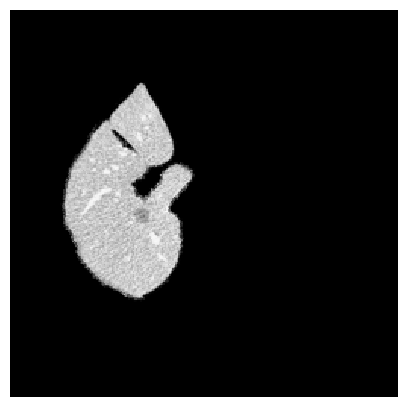

In [60]:
x, y = valid_gen.__getitem__(40)
result = model.predict(x)

result = result > 0.5

imshow(x[1])


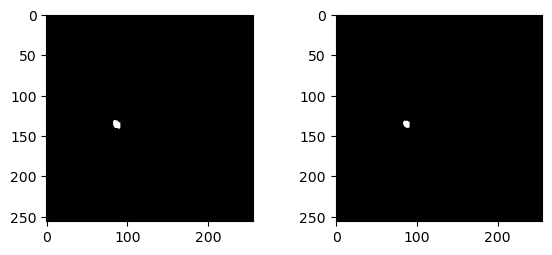

In [61]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")

1/1 [==============================] - 0s 383ms/step


/var/folders/w7/y5klds4x3_53168tgqlttv6w0000gn/T/ipykernel_12367/2402579901.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(20,20))


1/1 [==============================] - 0s 387ms/step


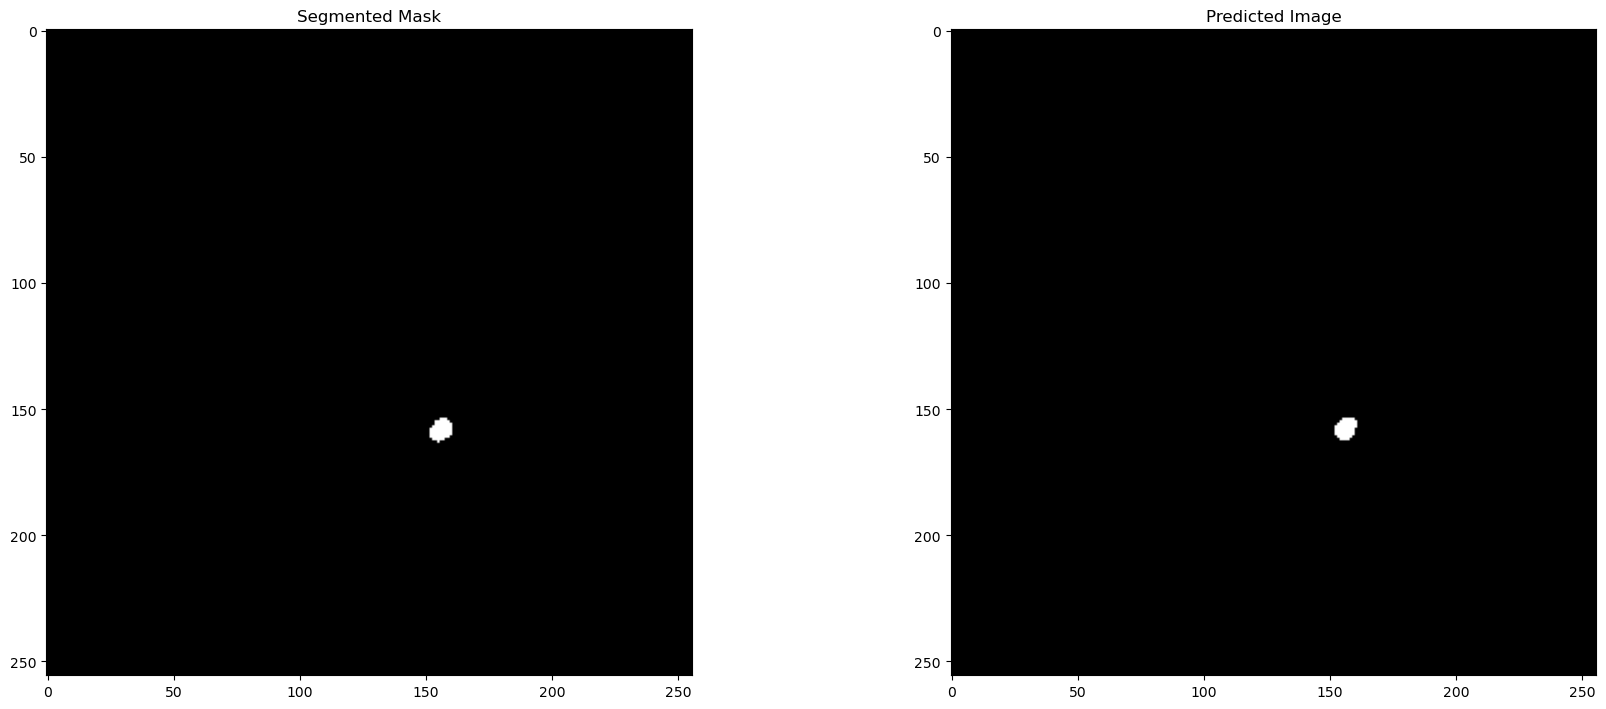

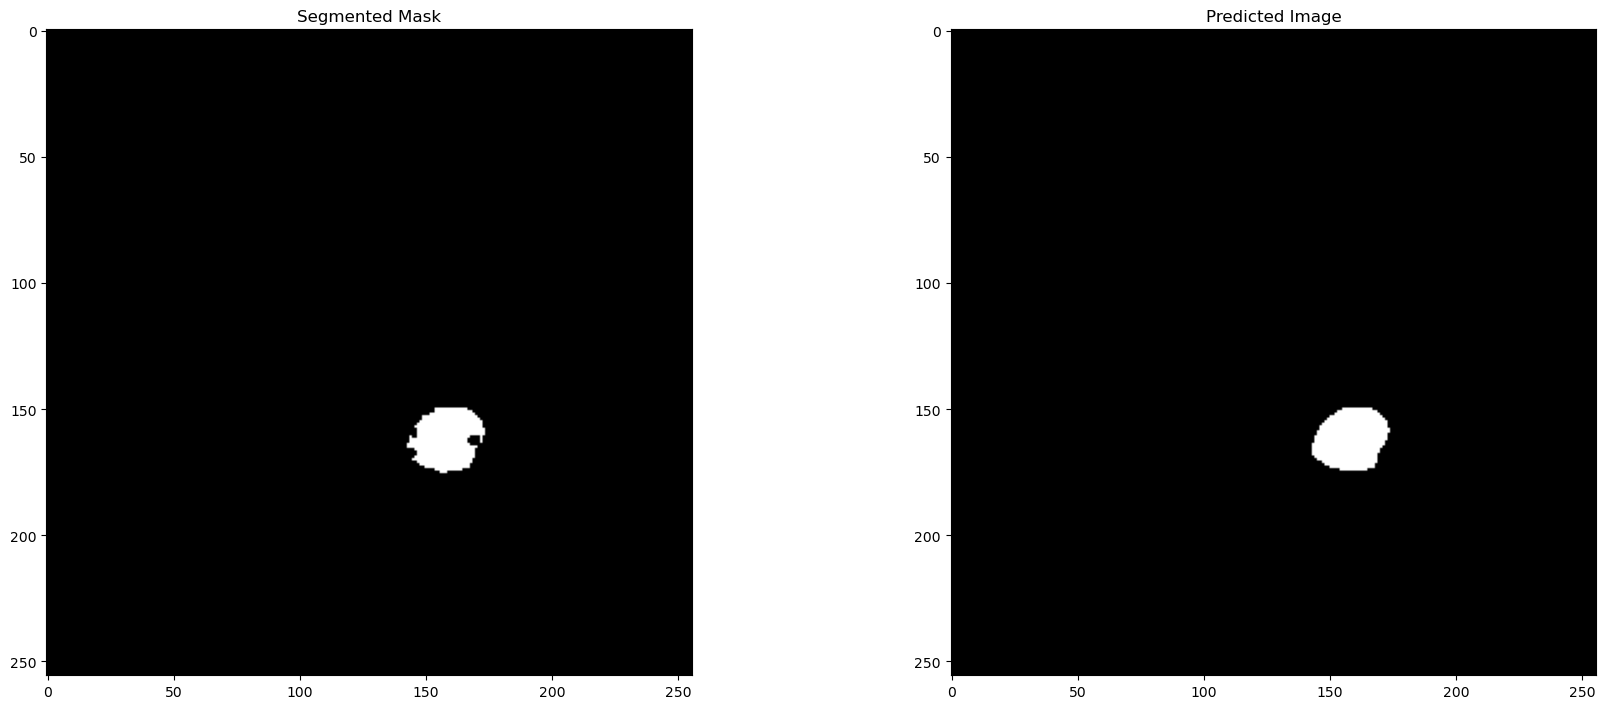

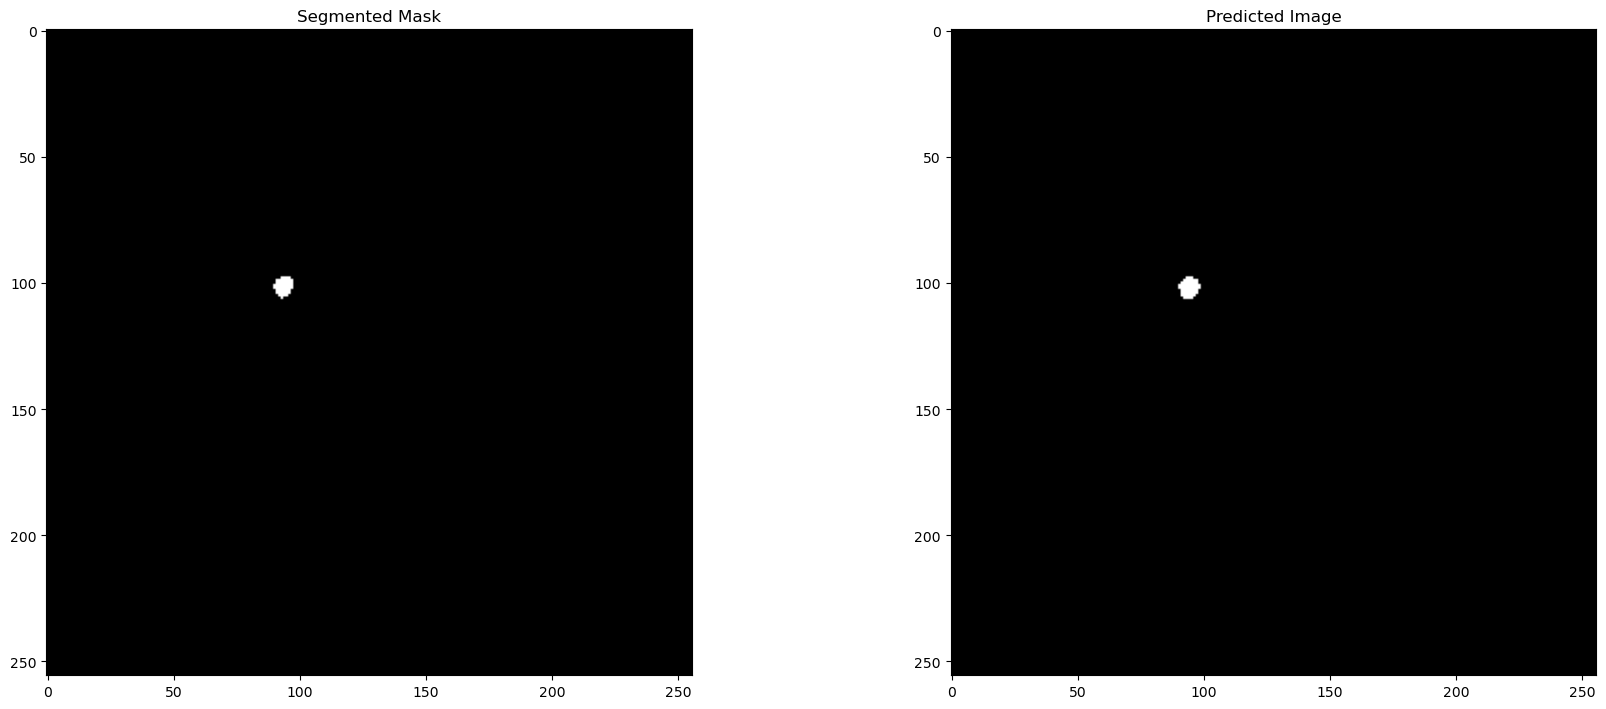

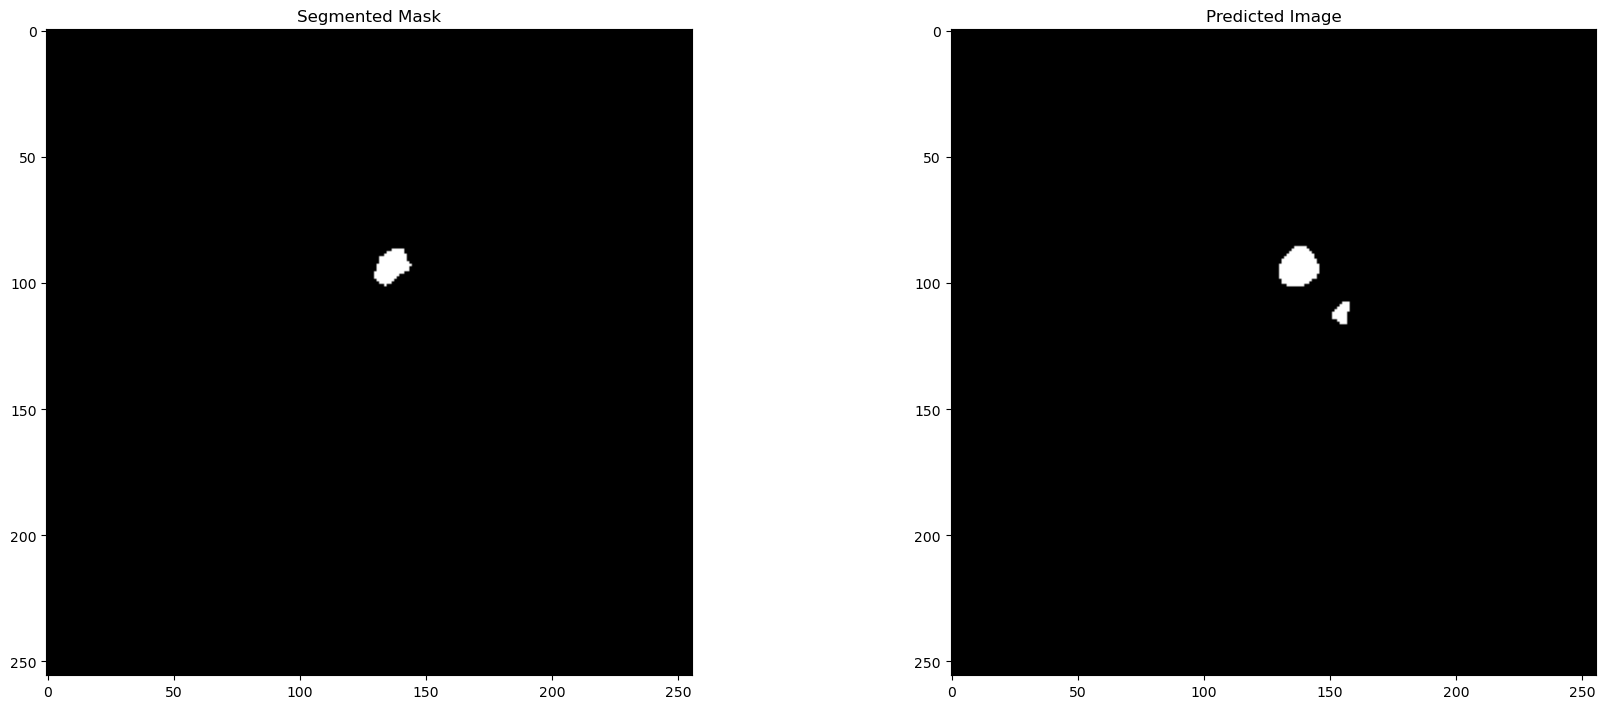

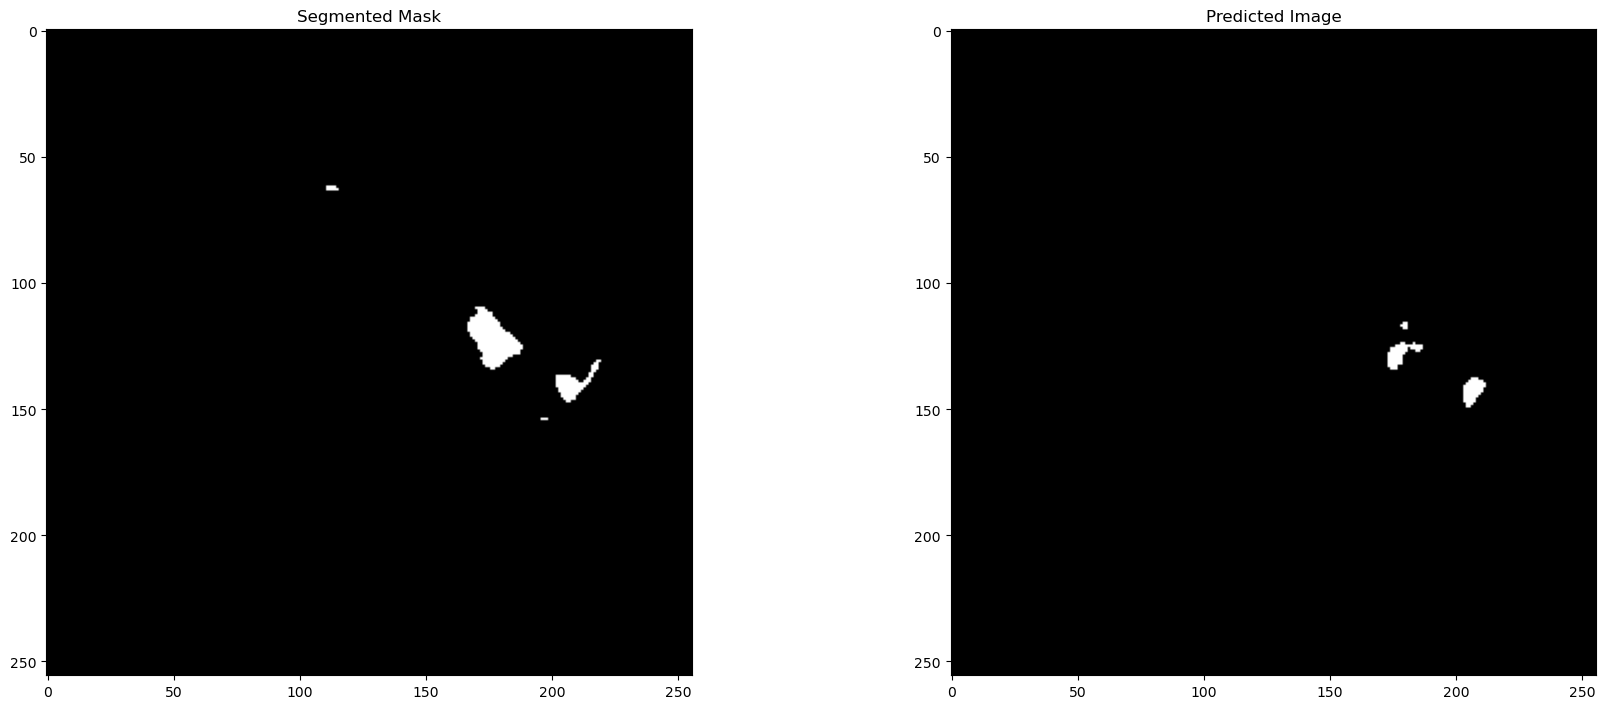

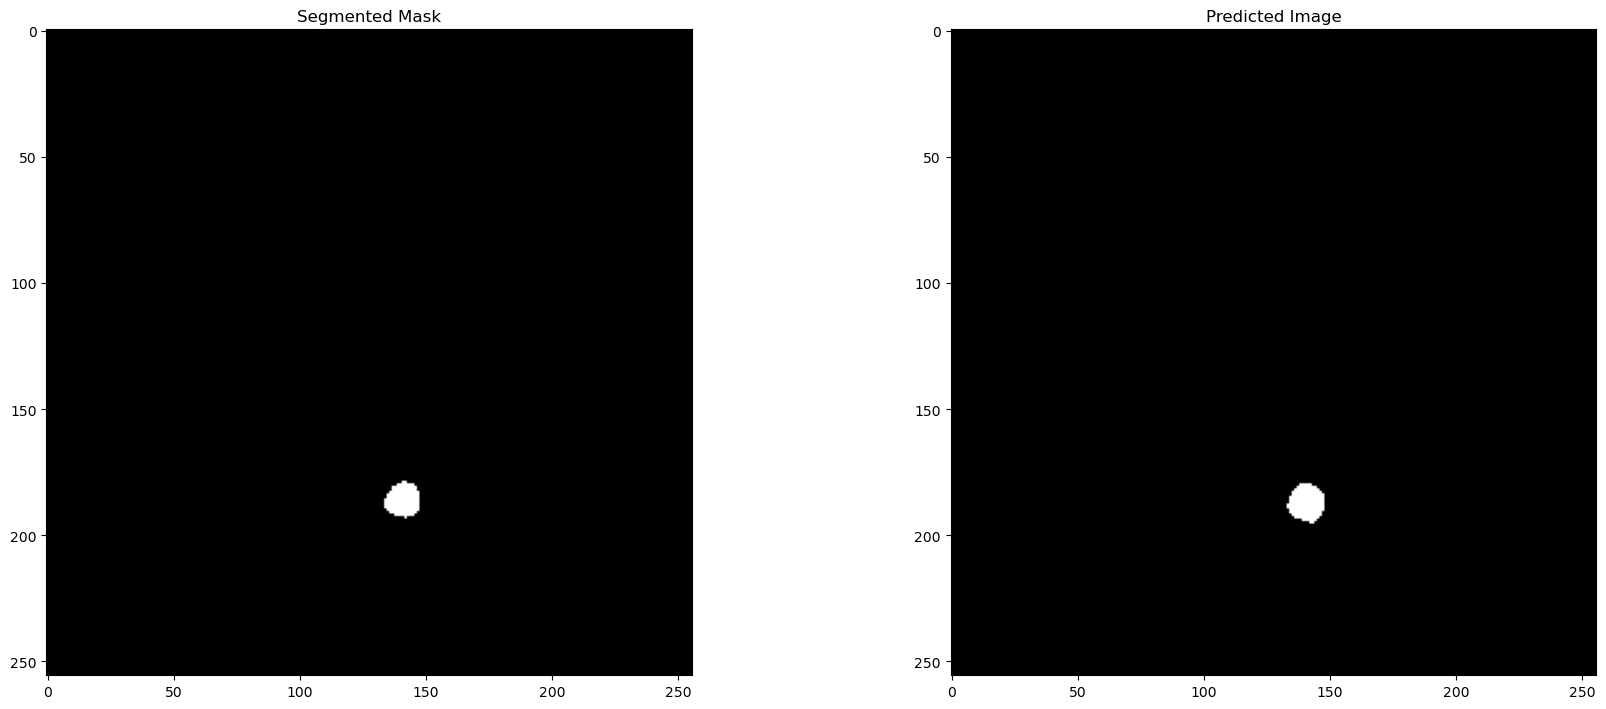

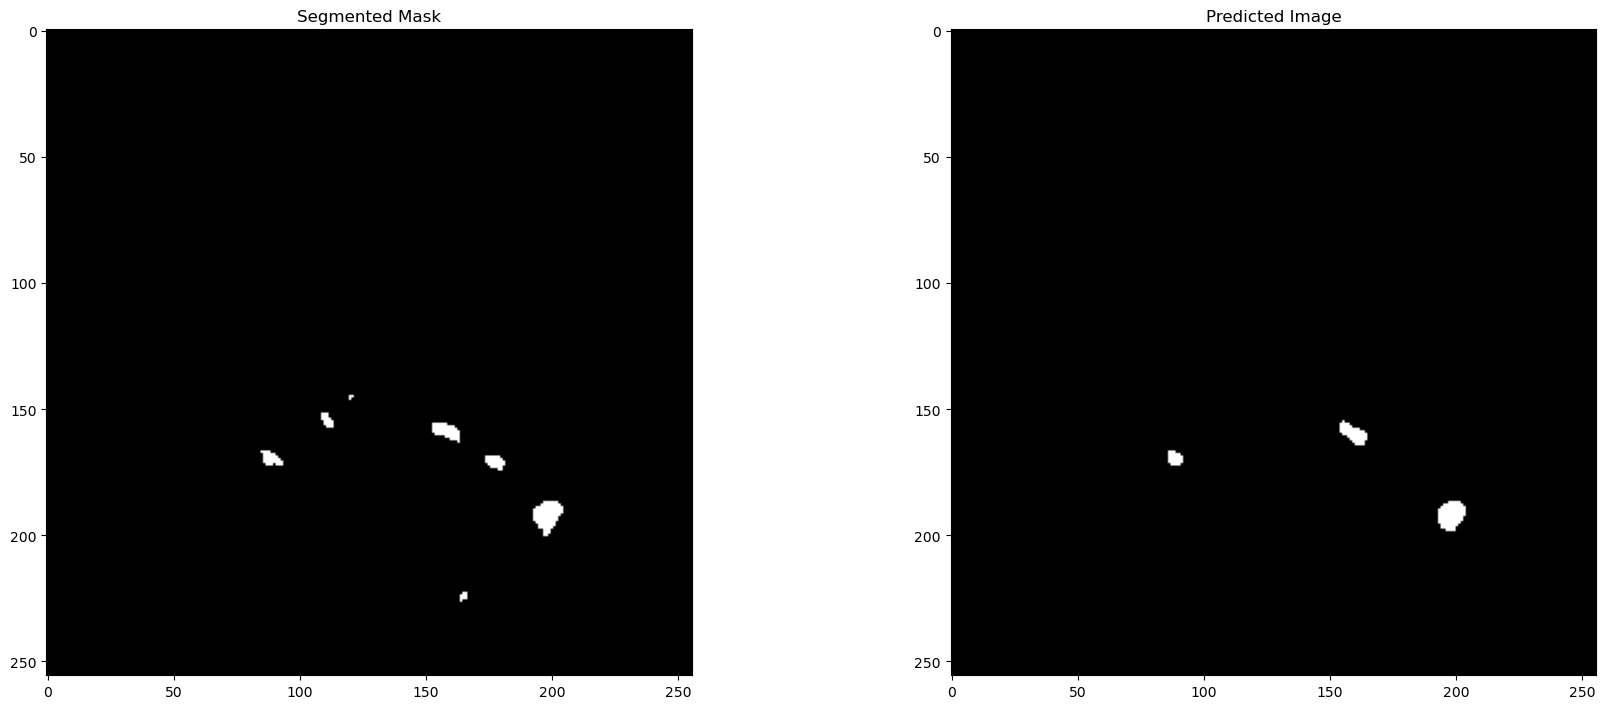

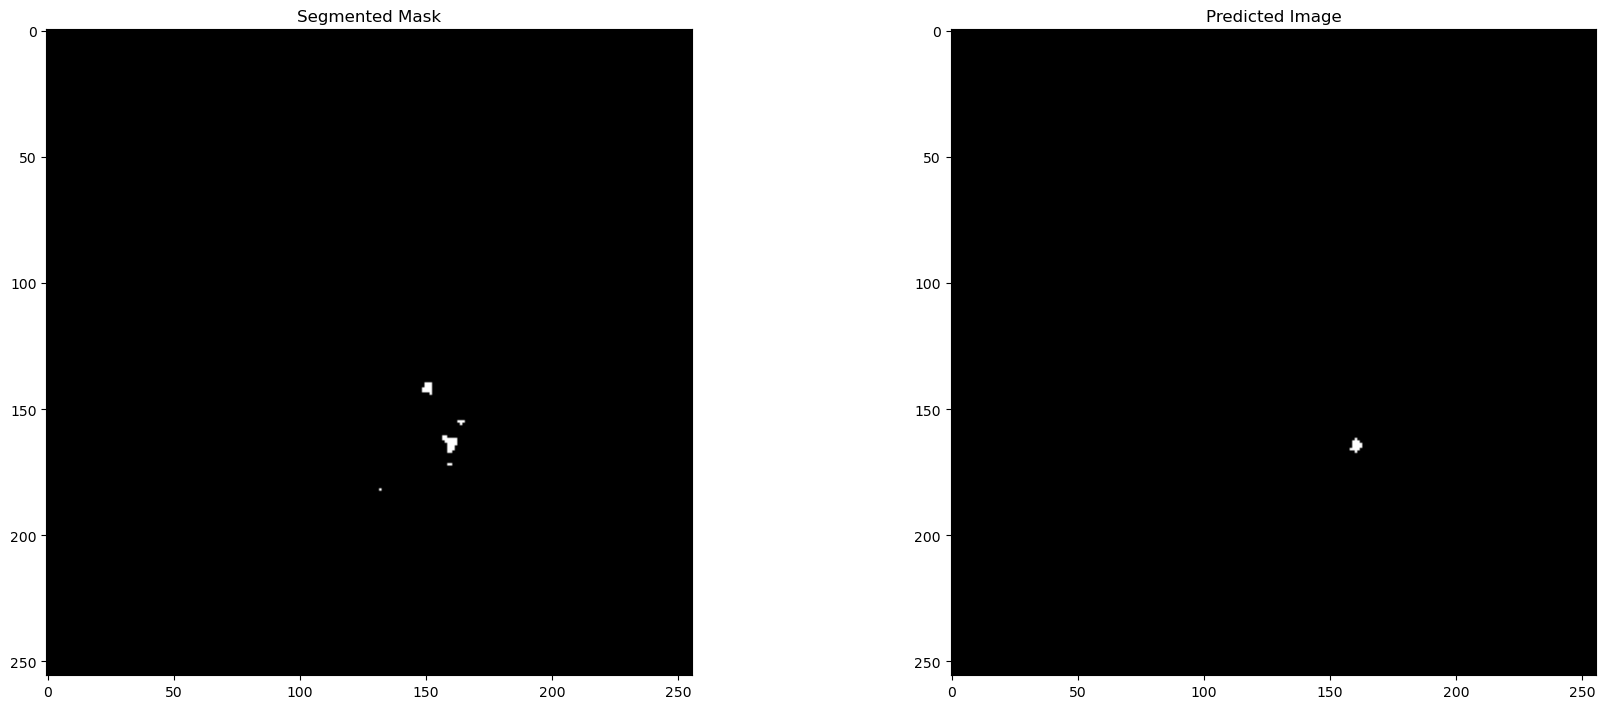

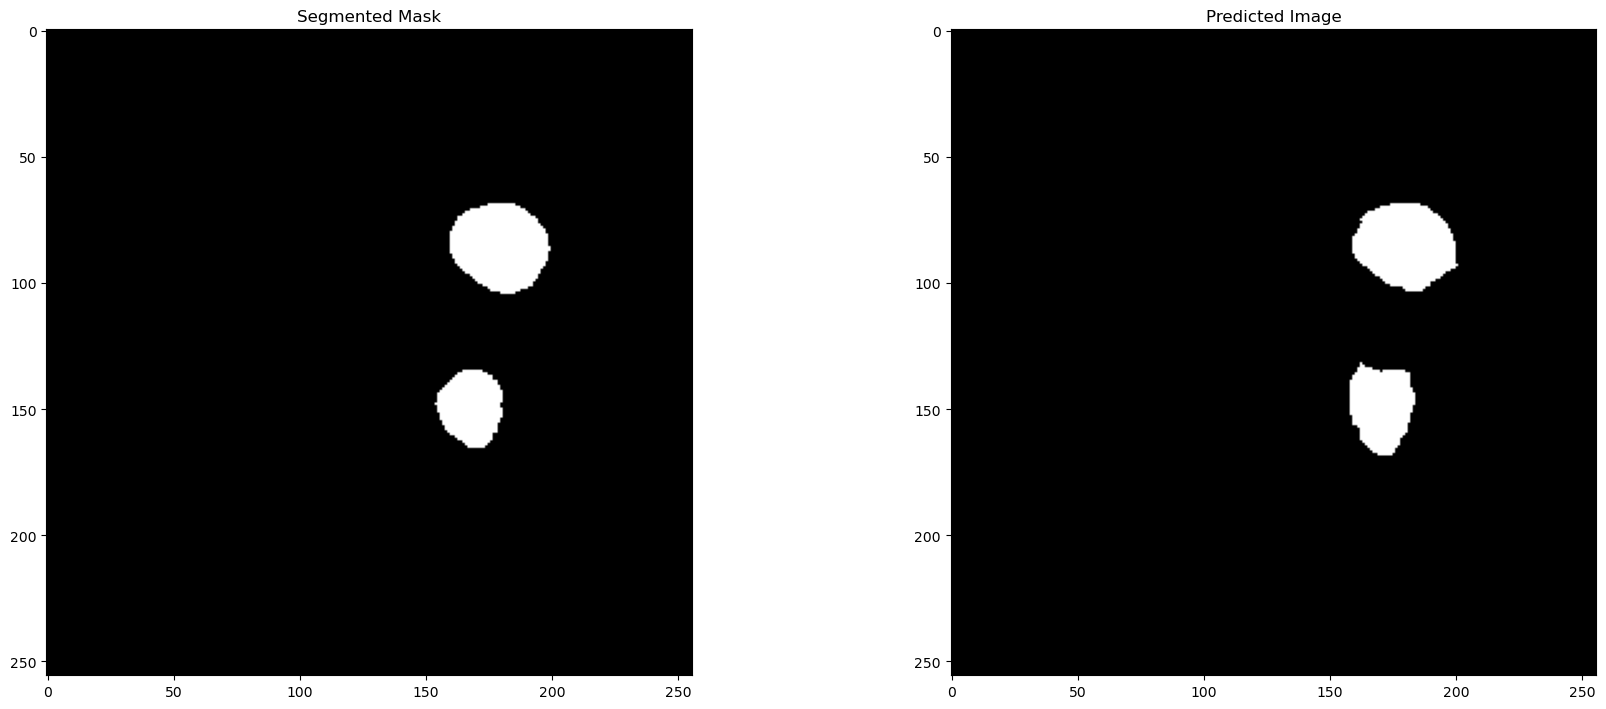

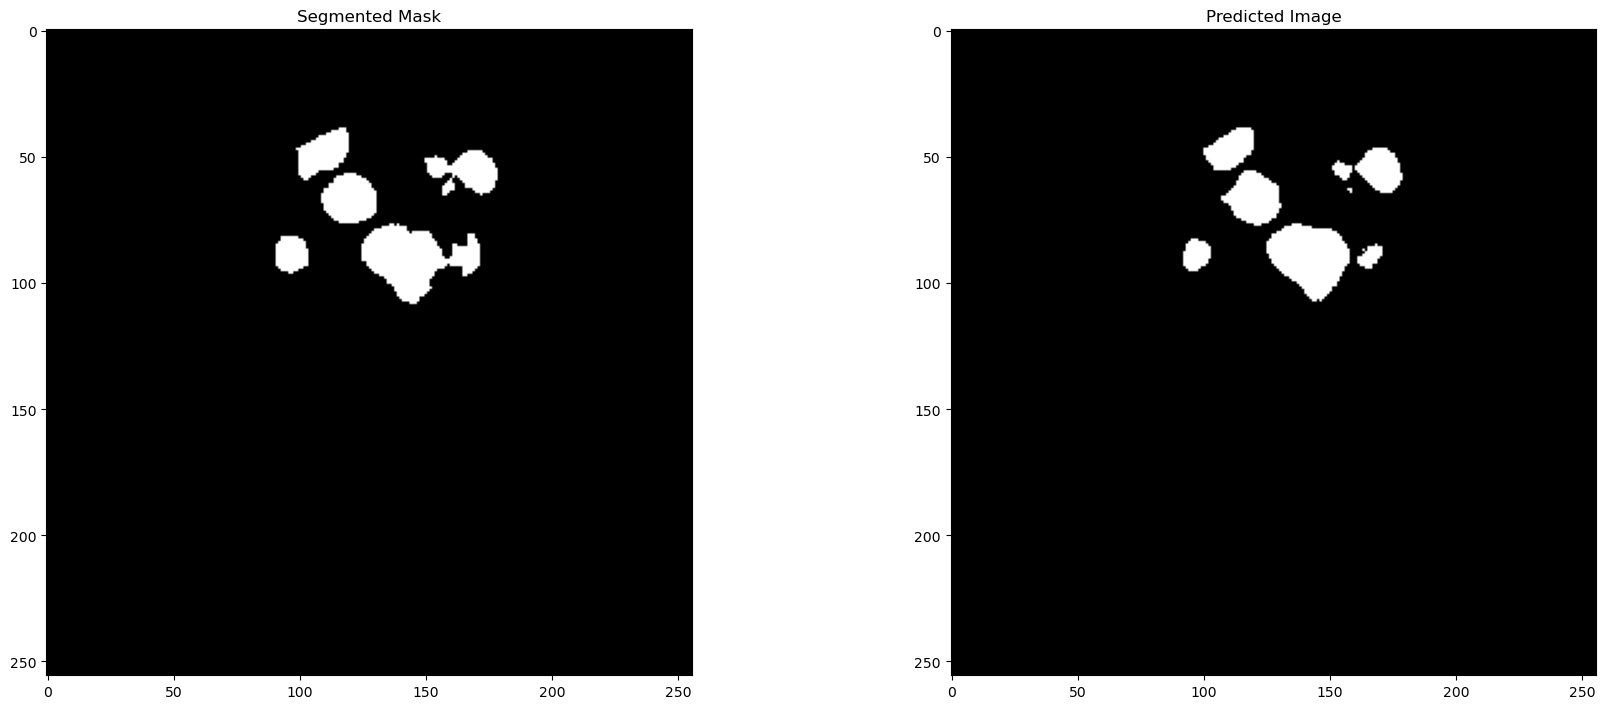

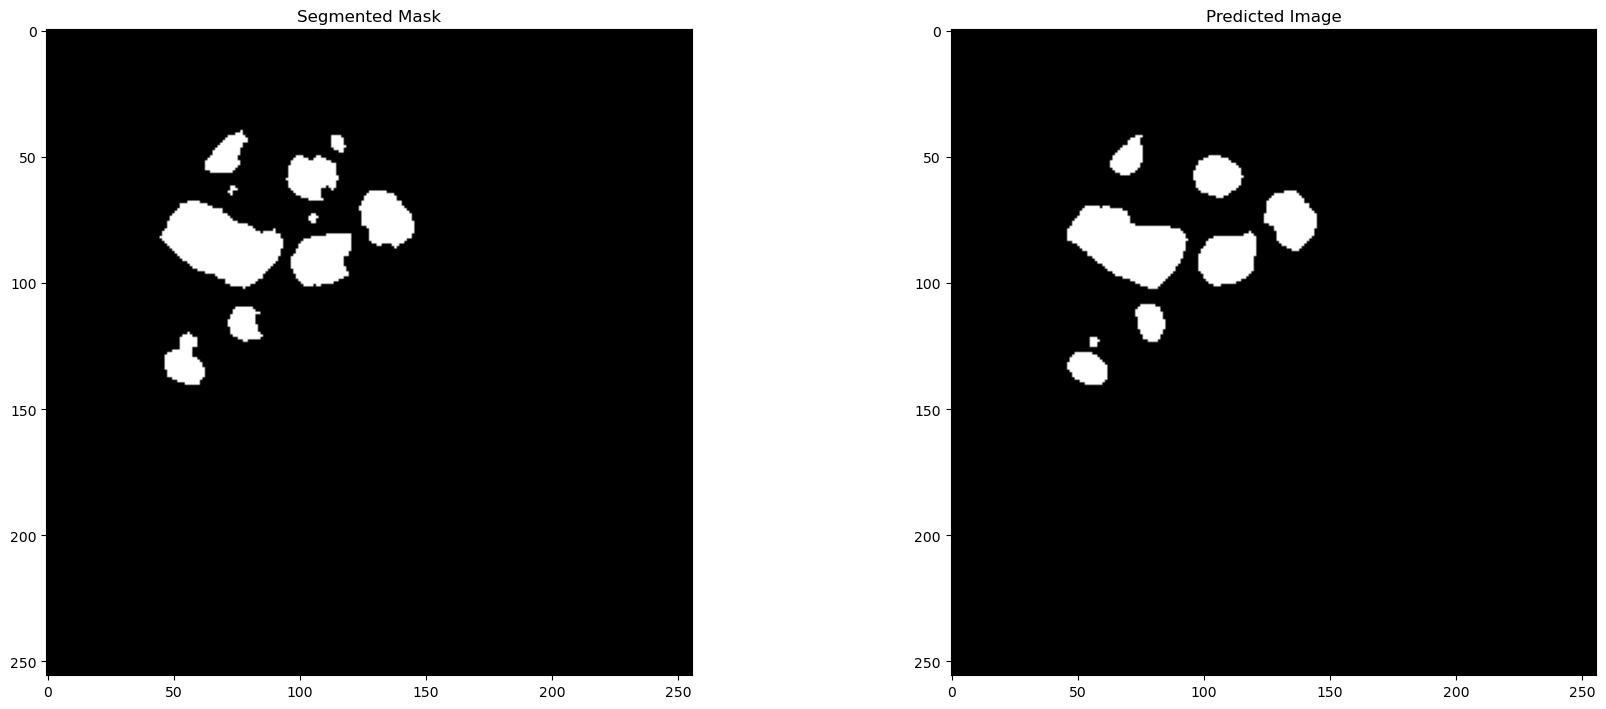

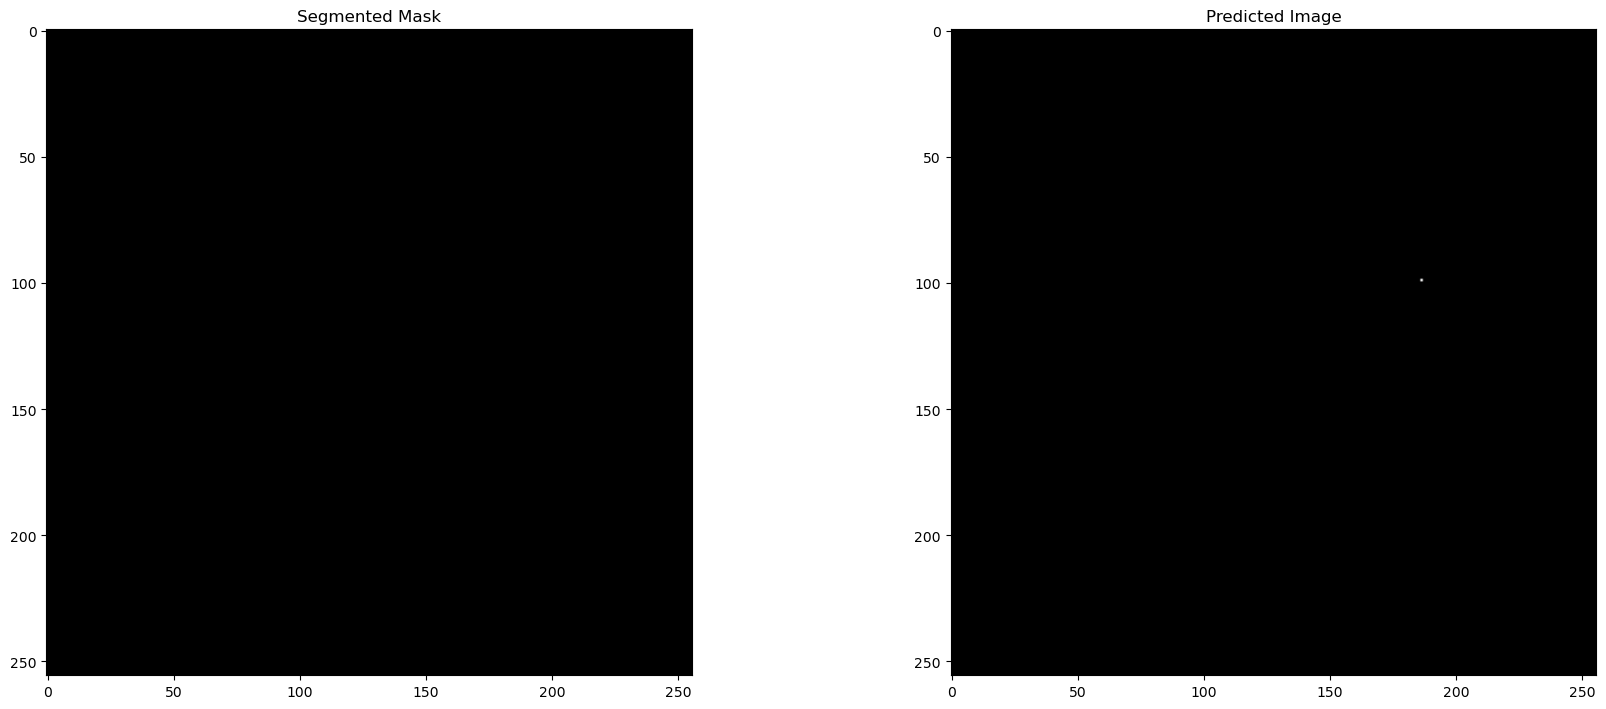

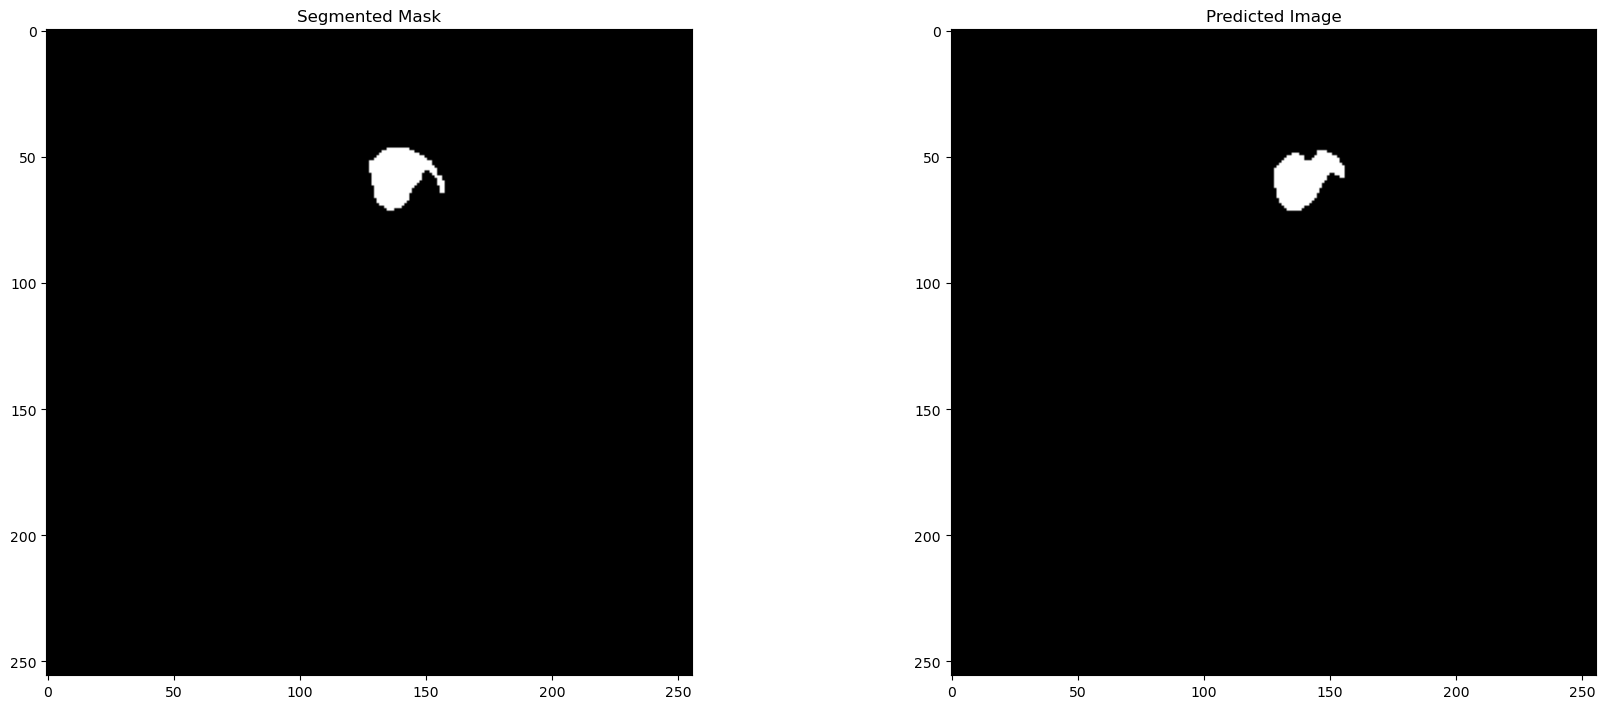

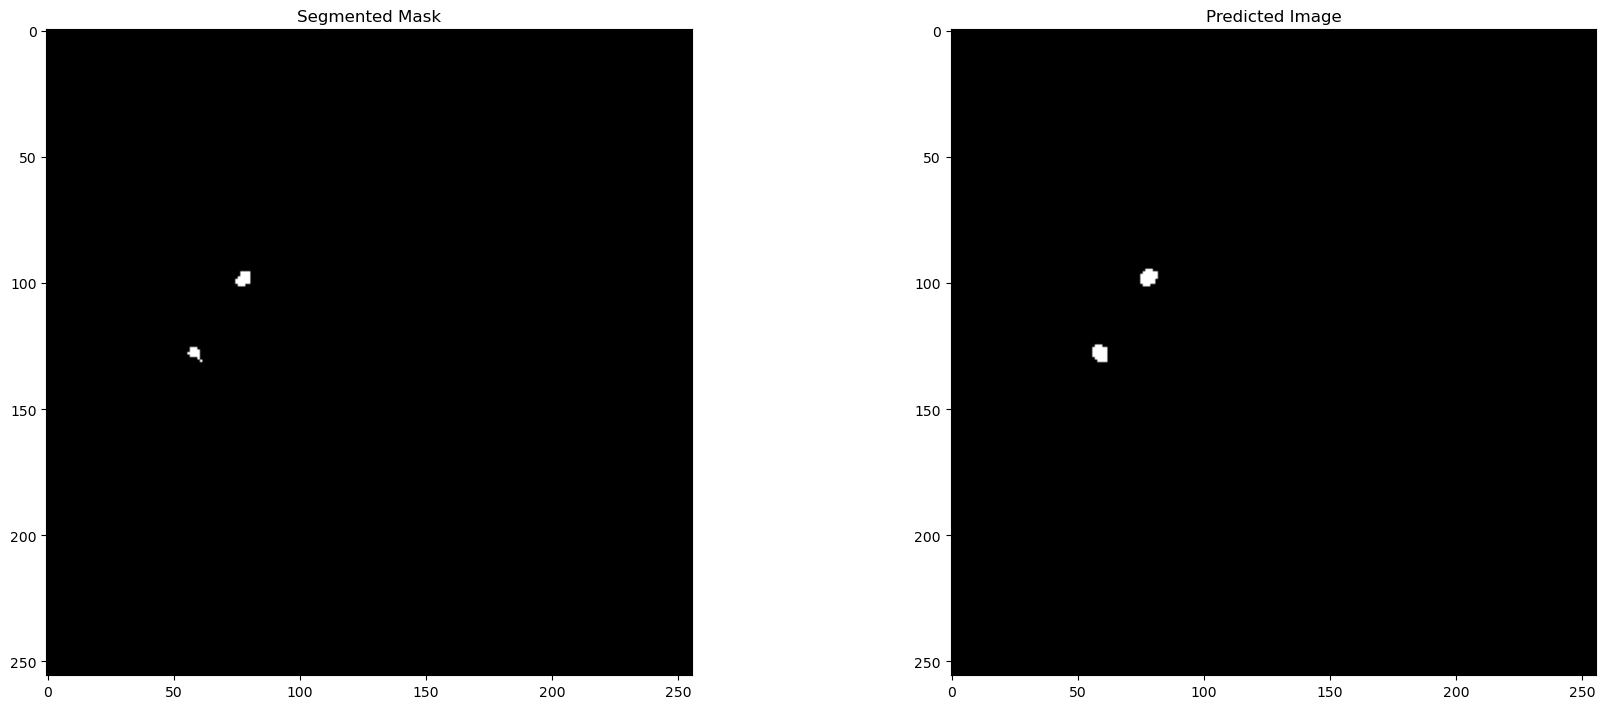

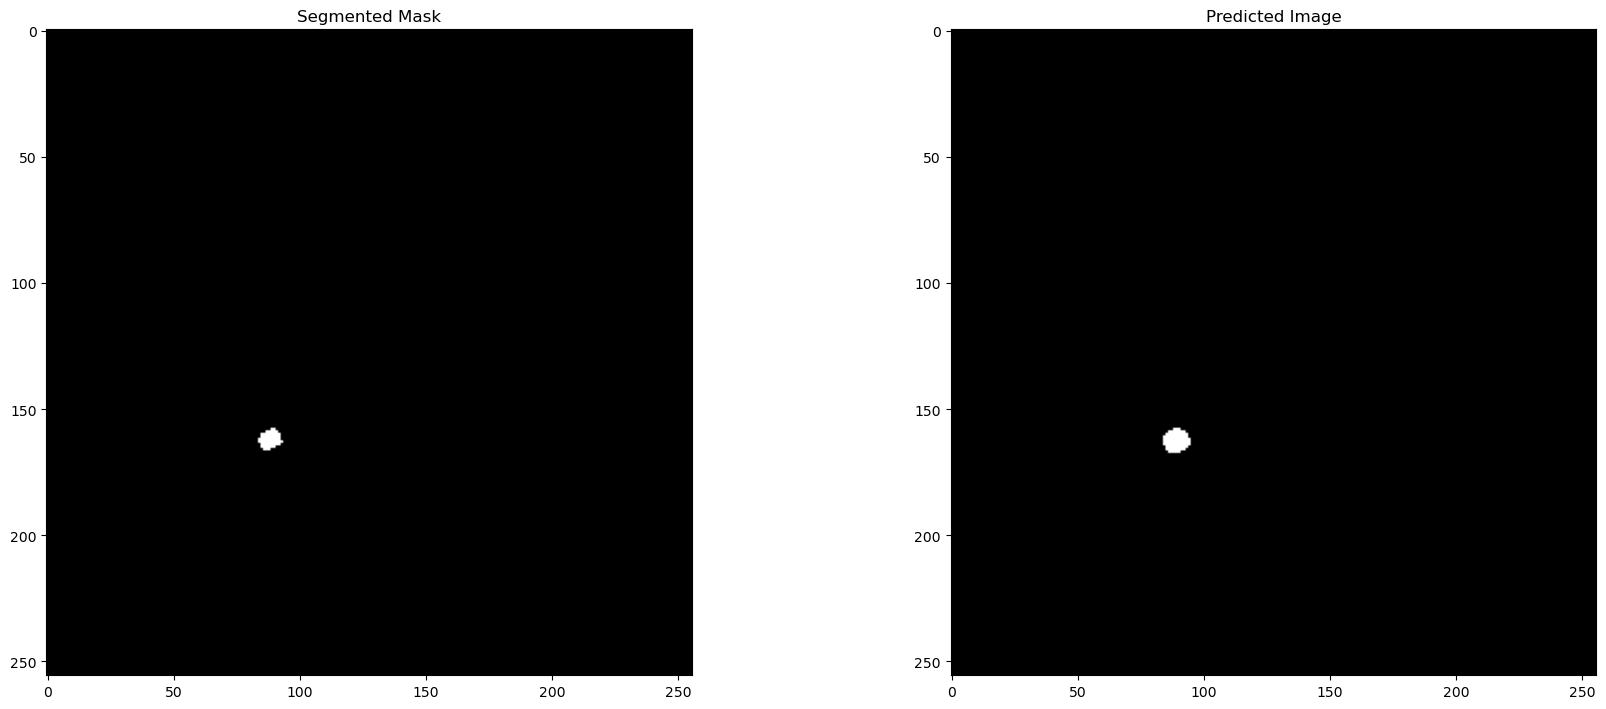

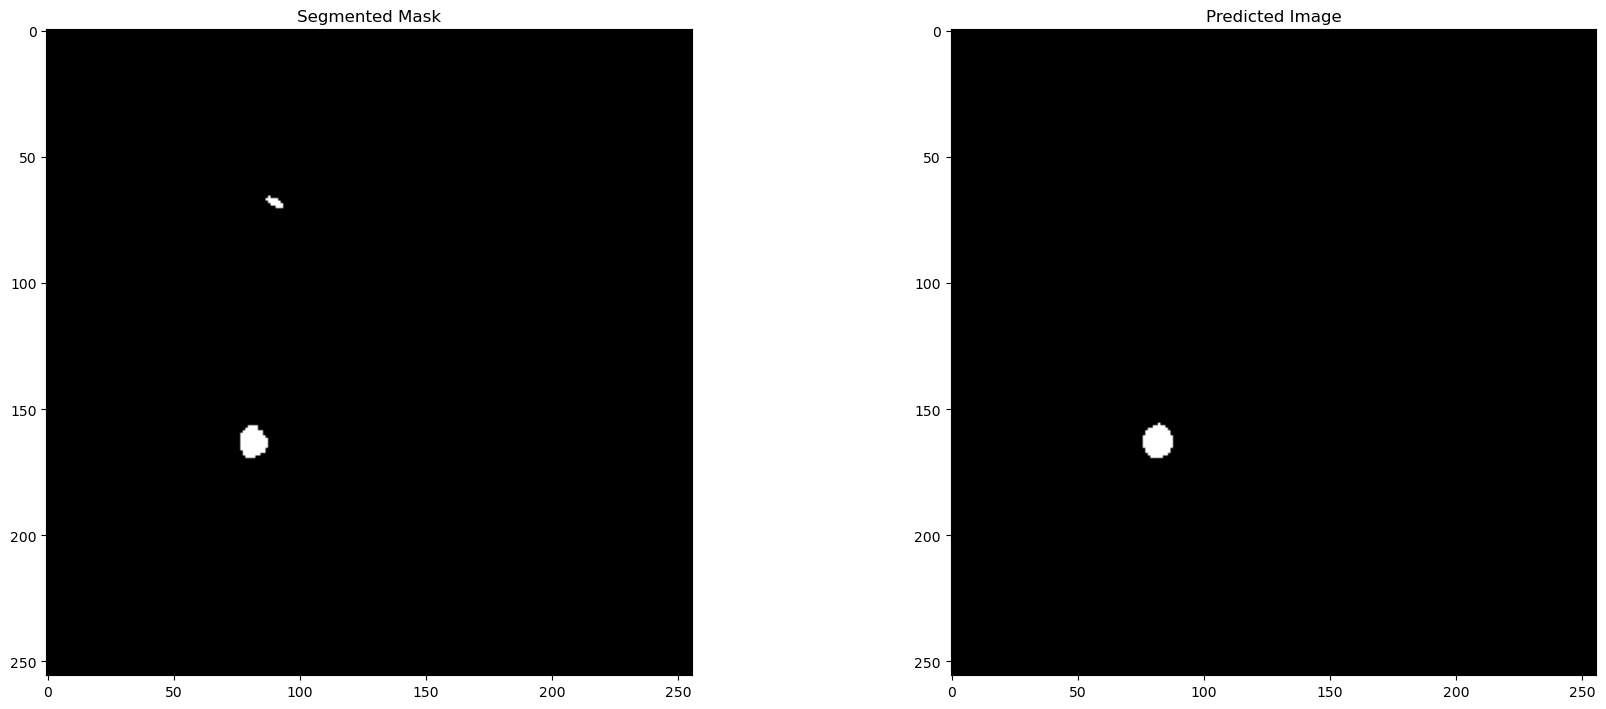

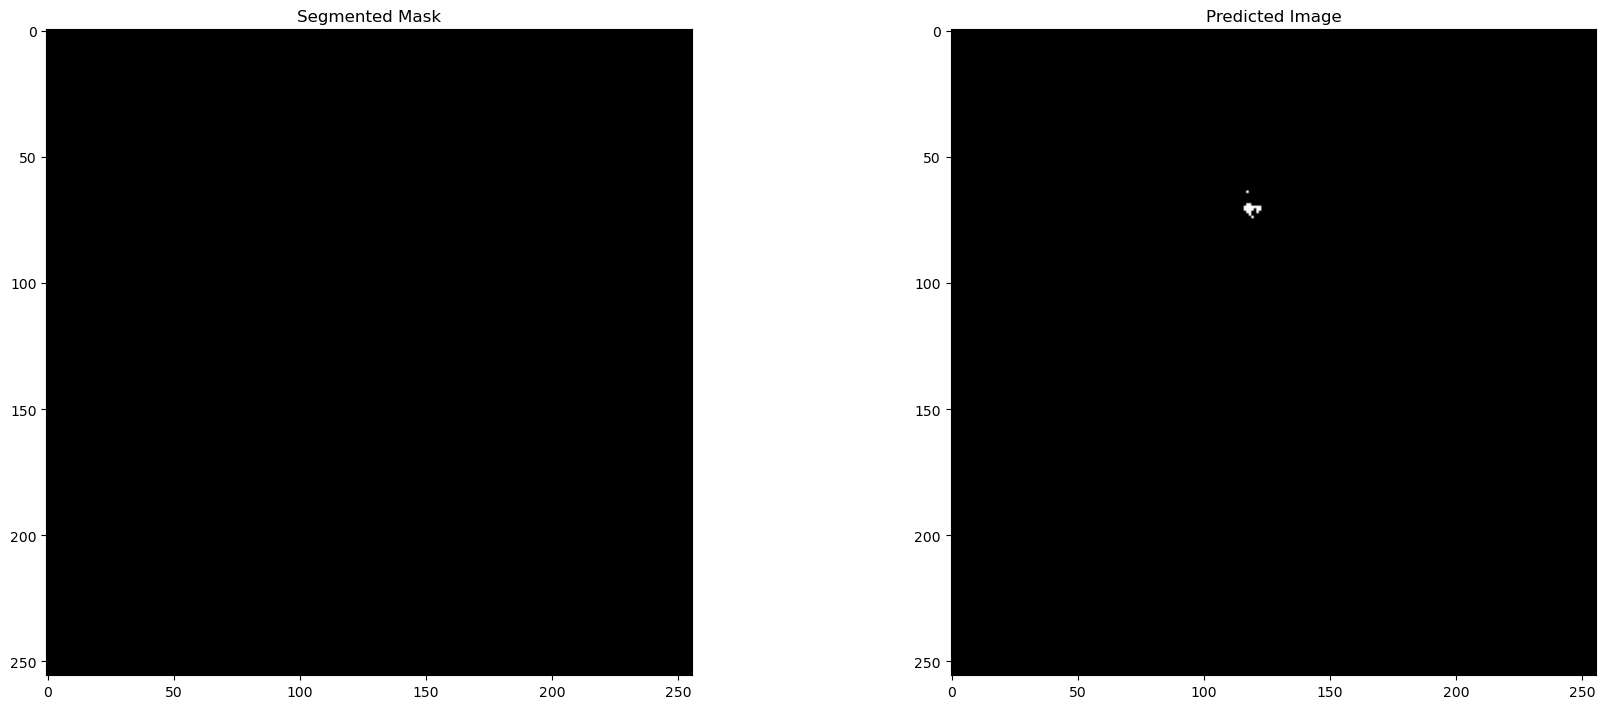

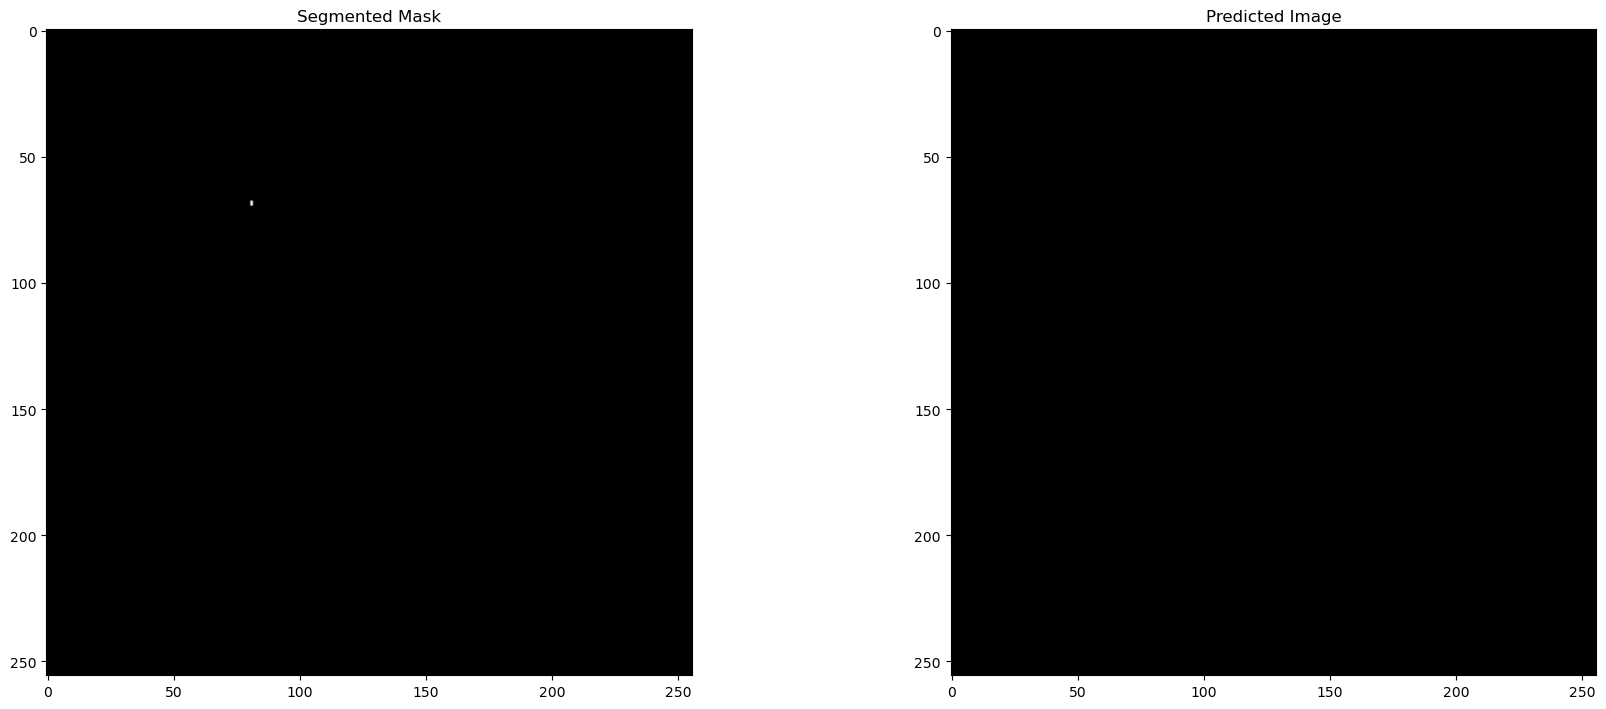

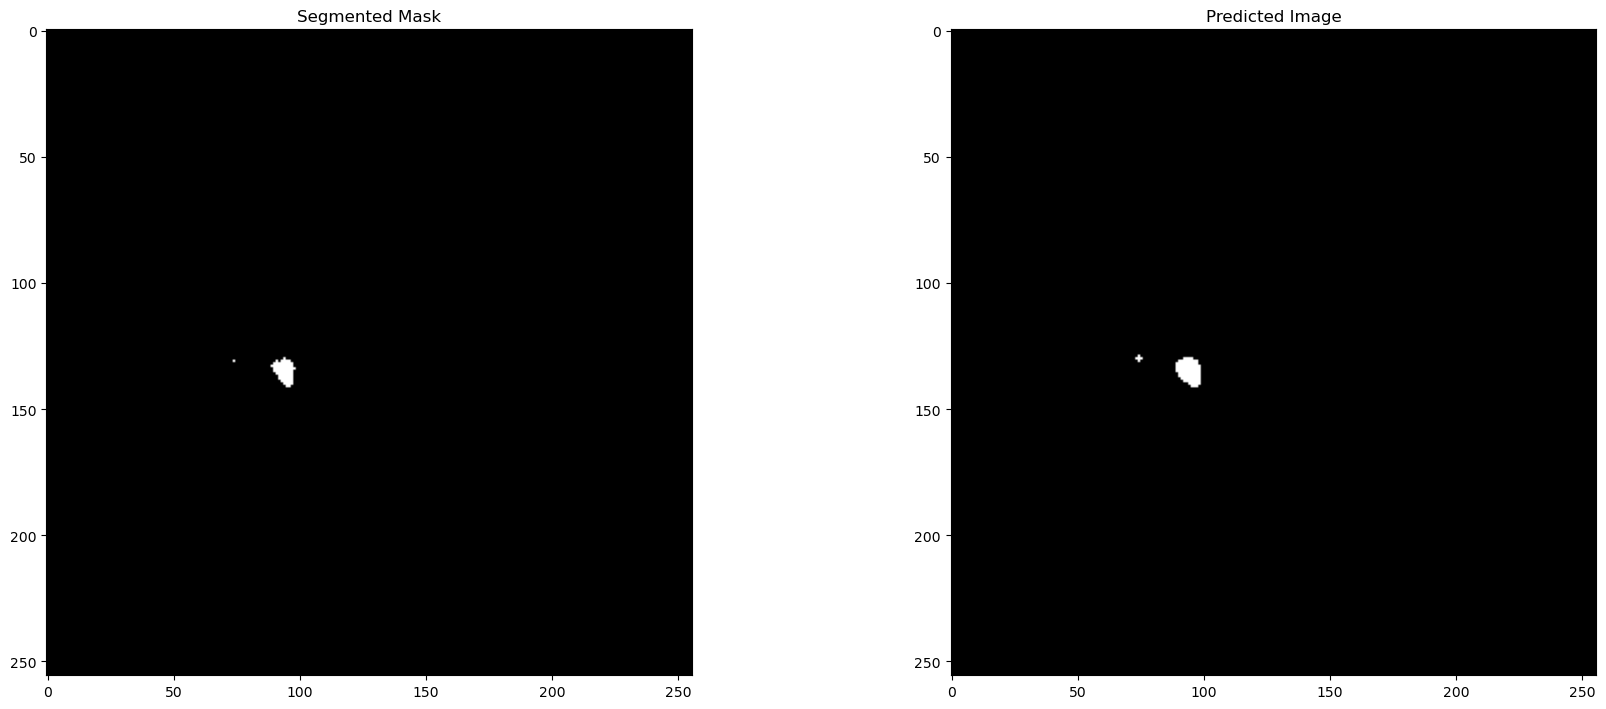

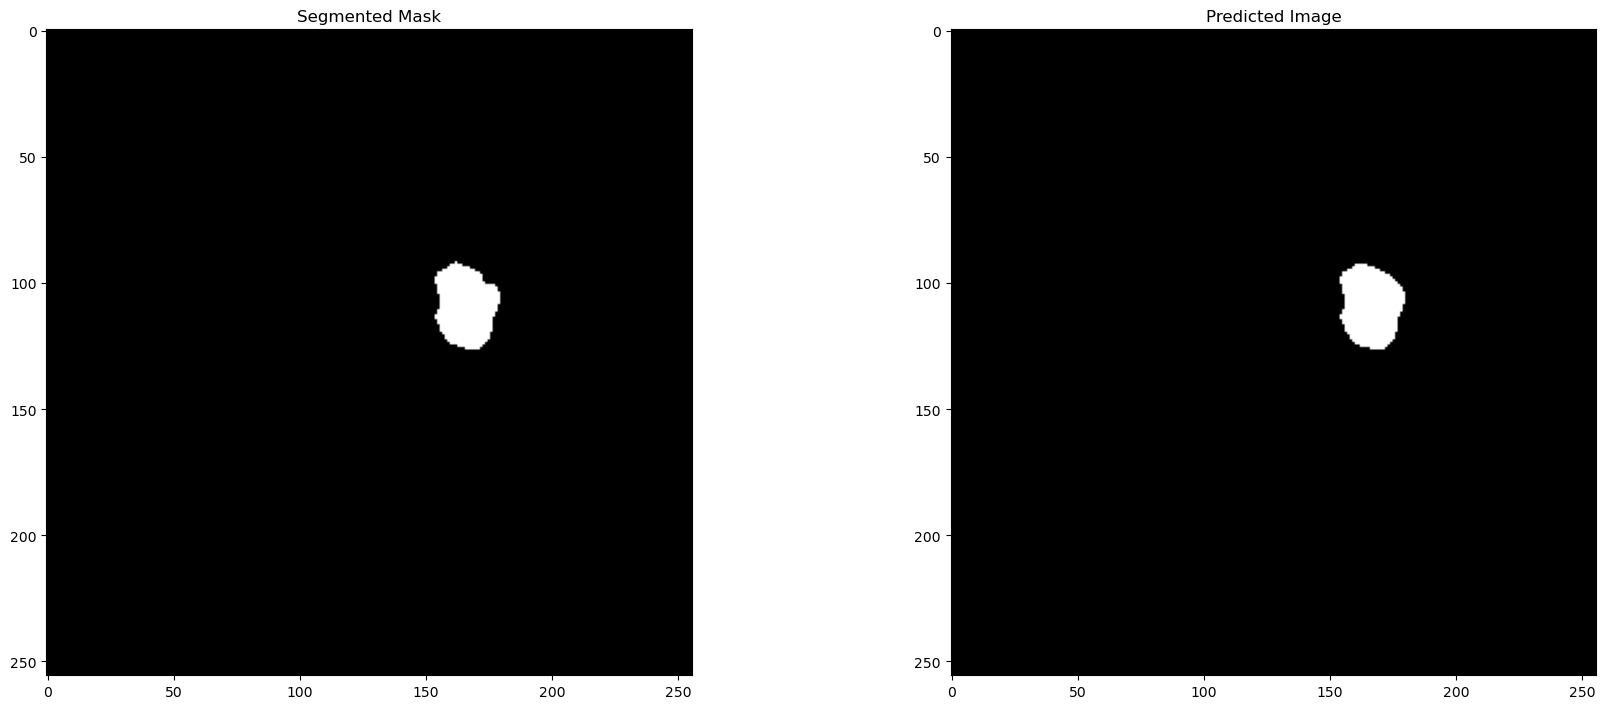

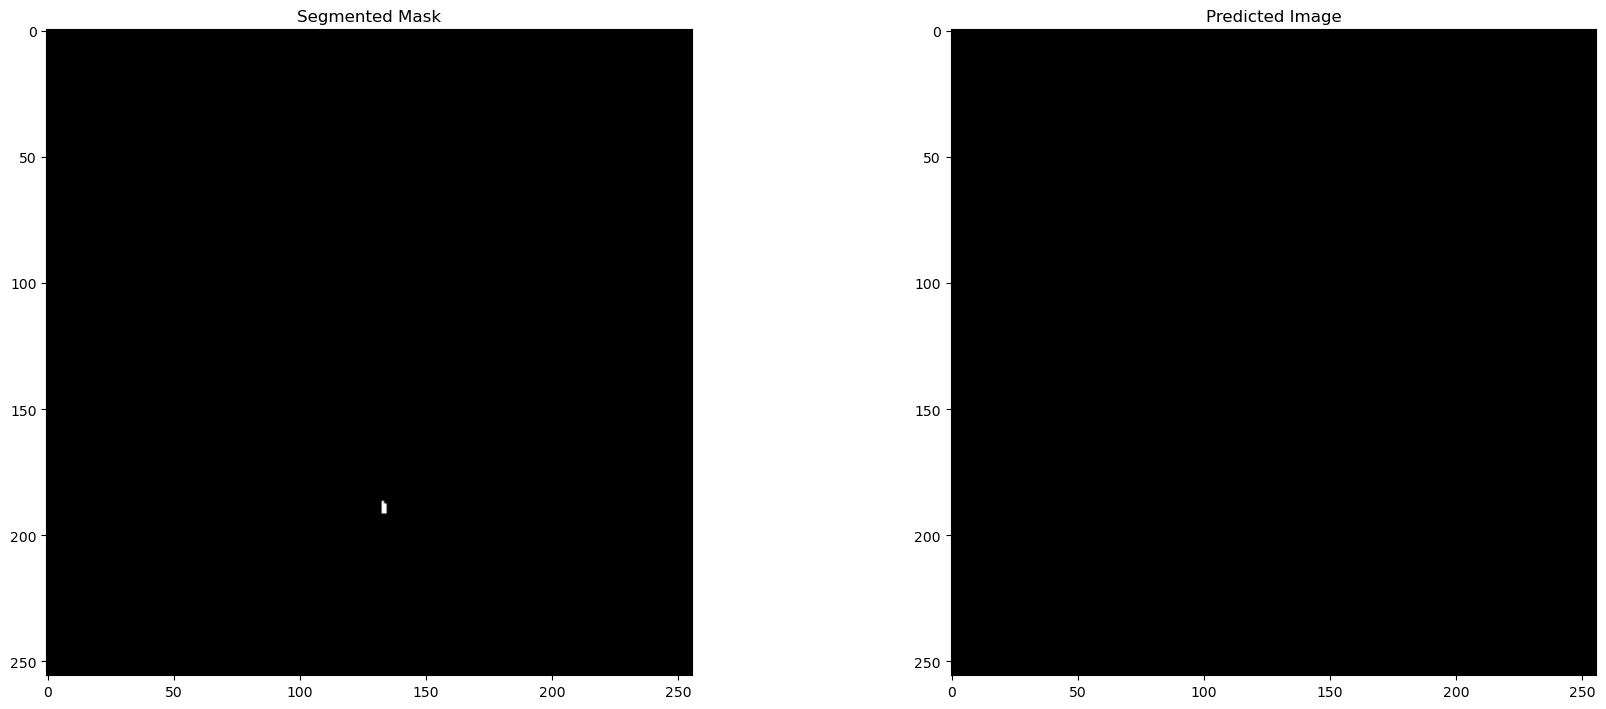

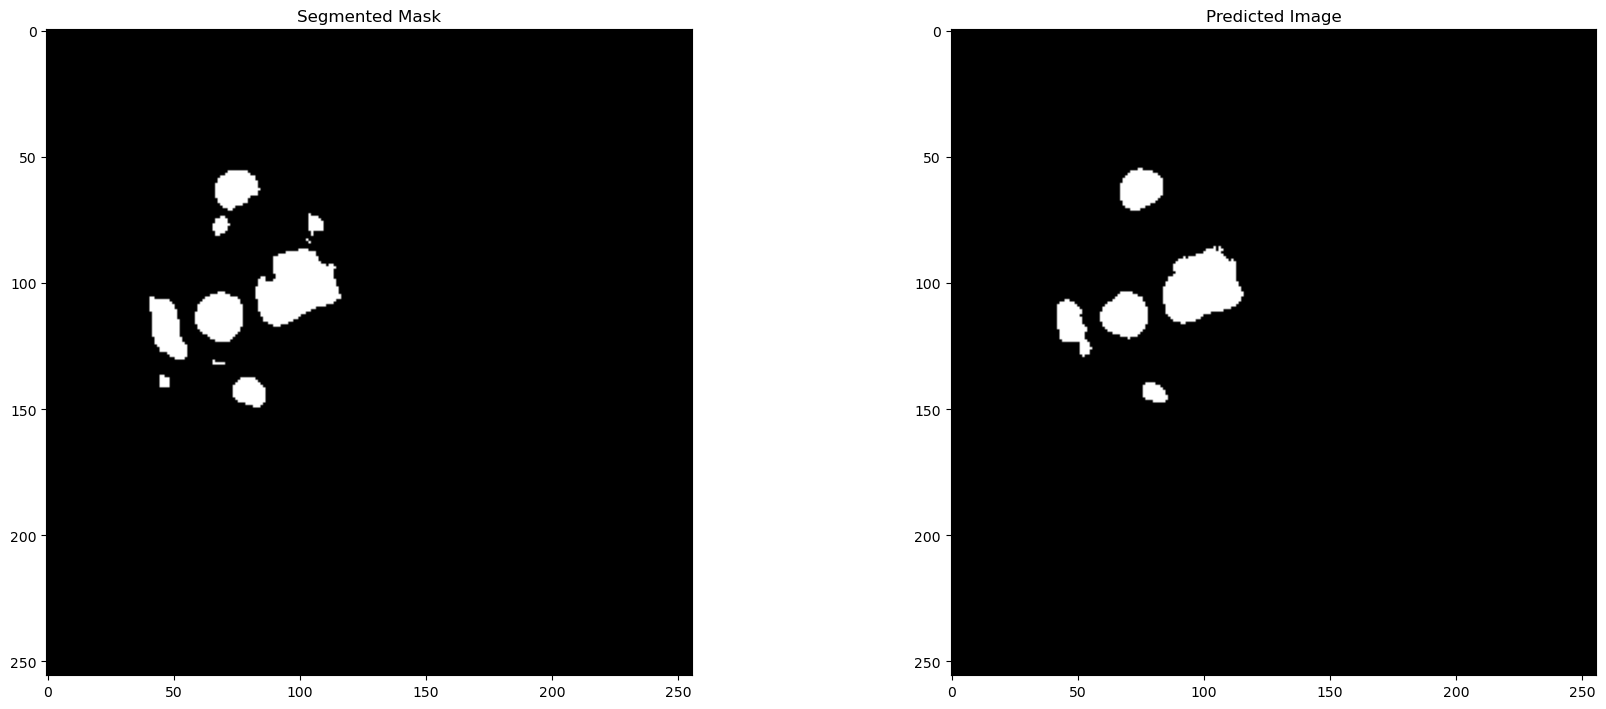

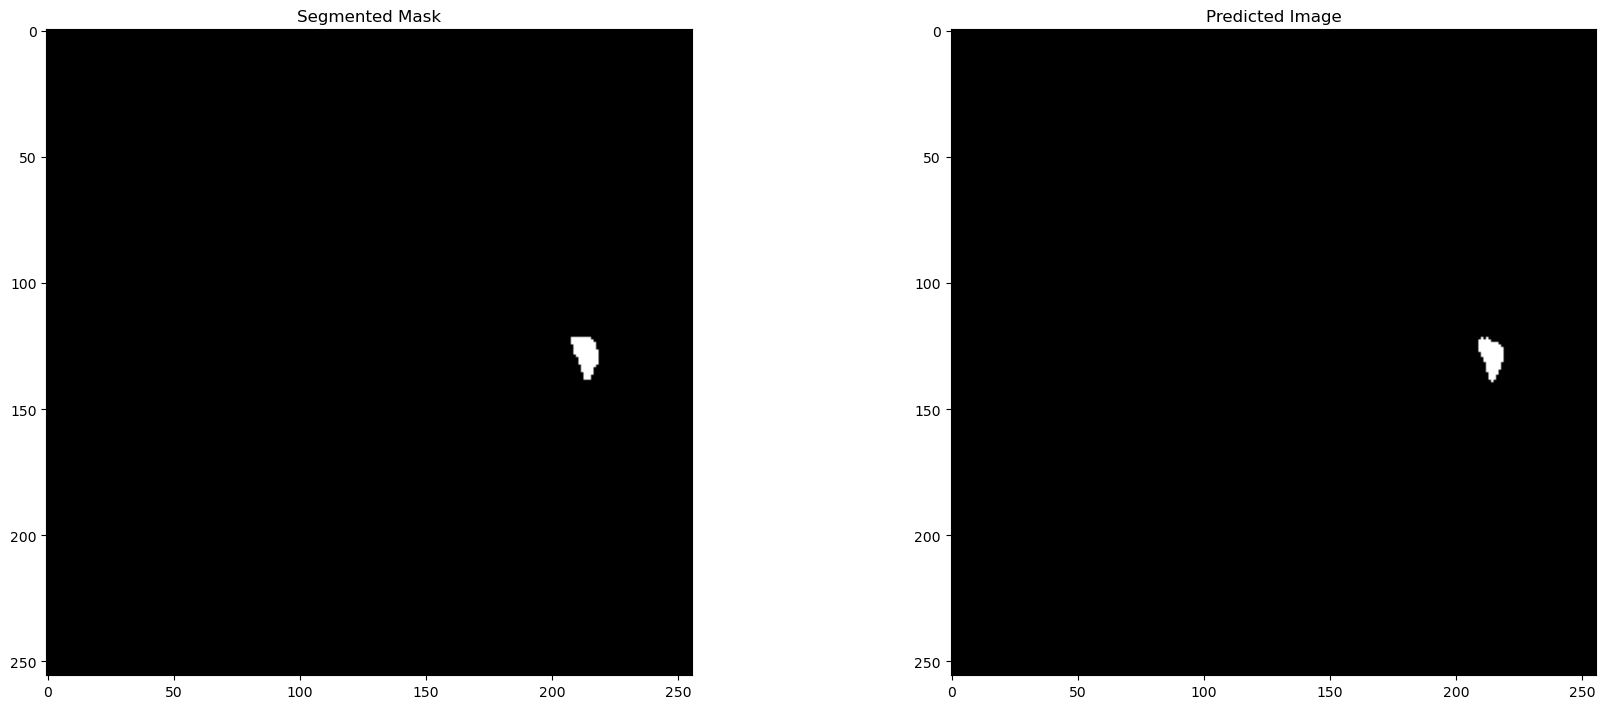

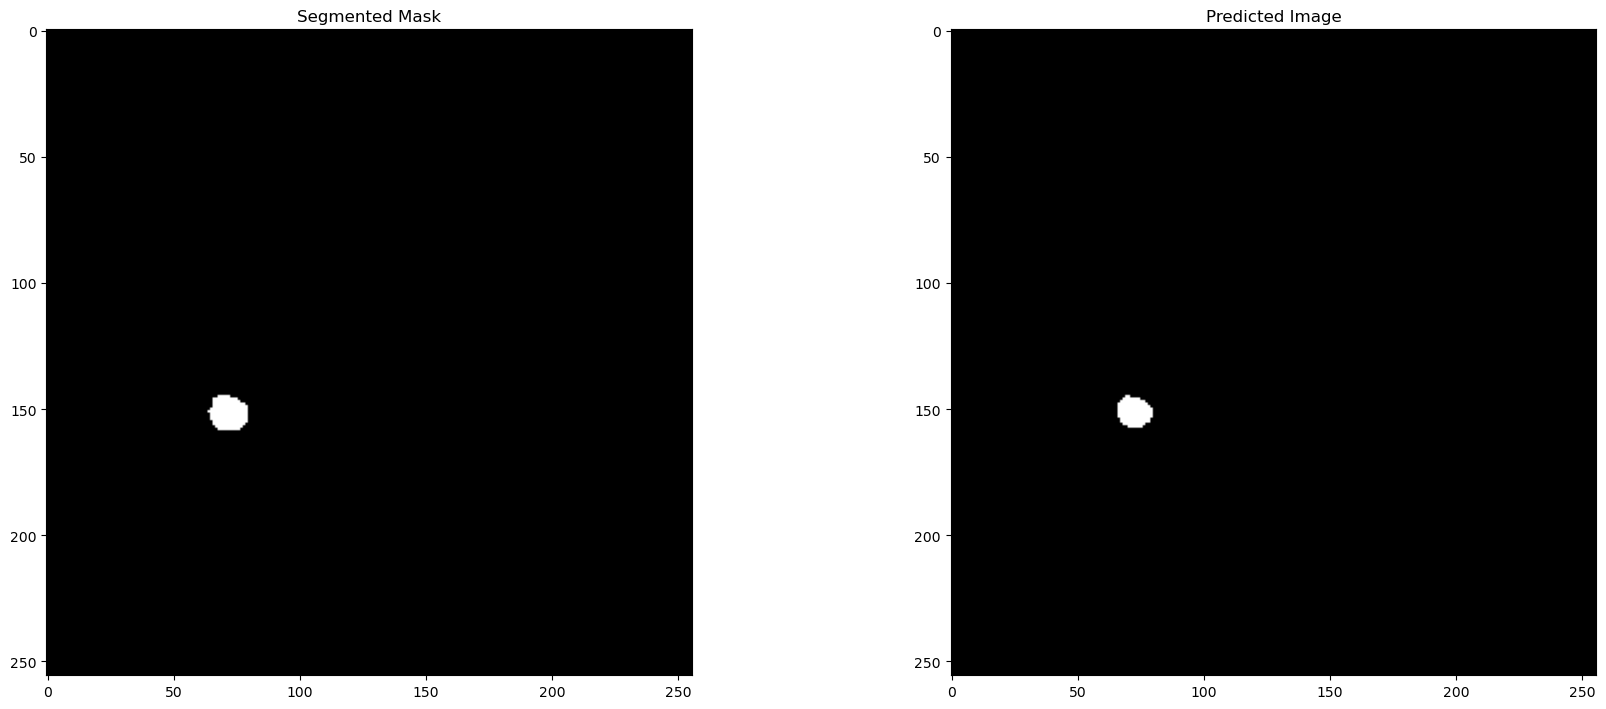

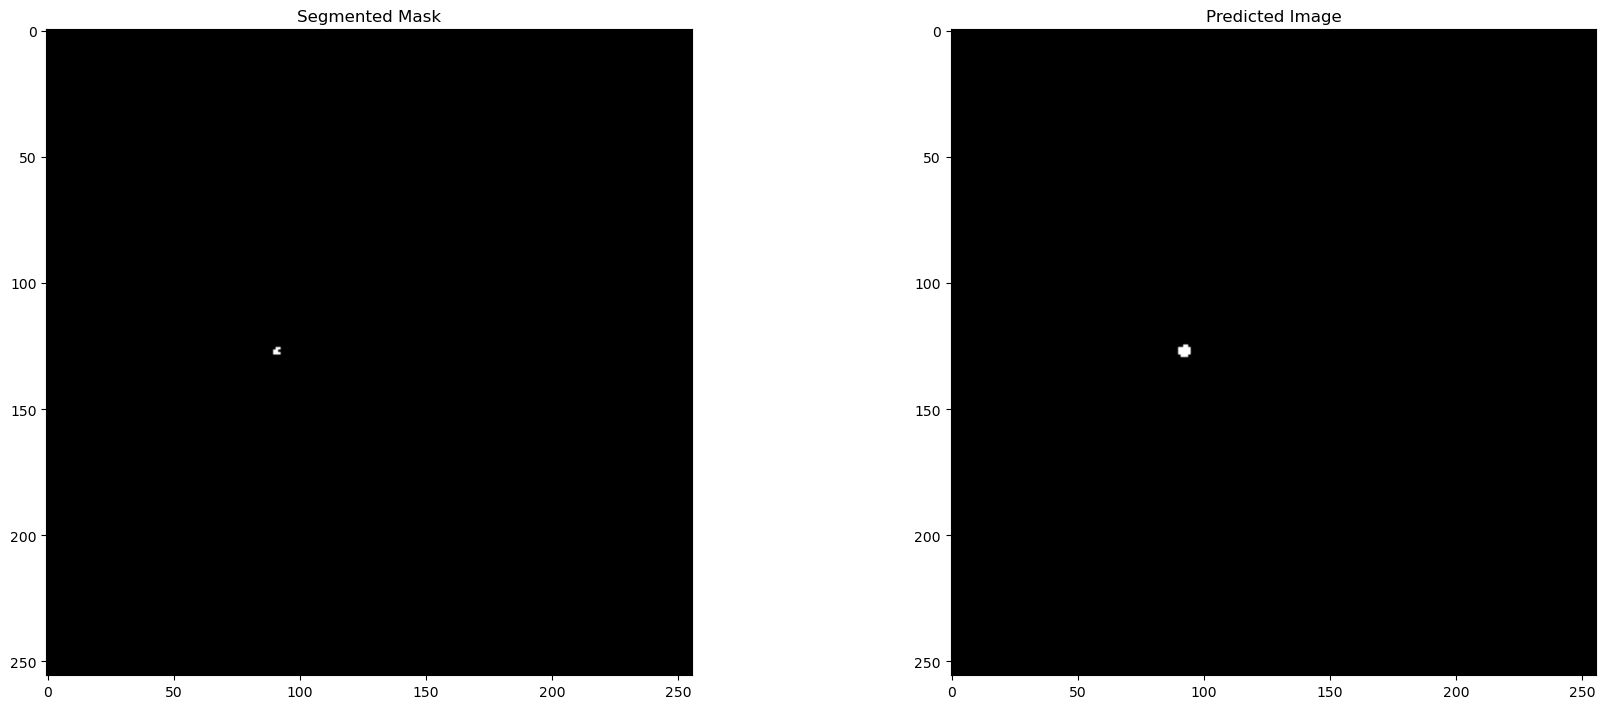

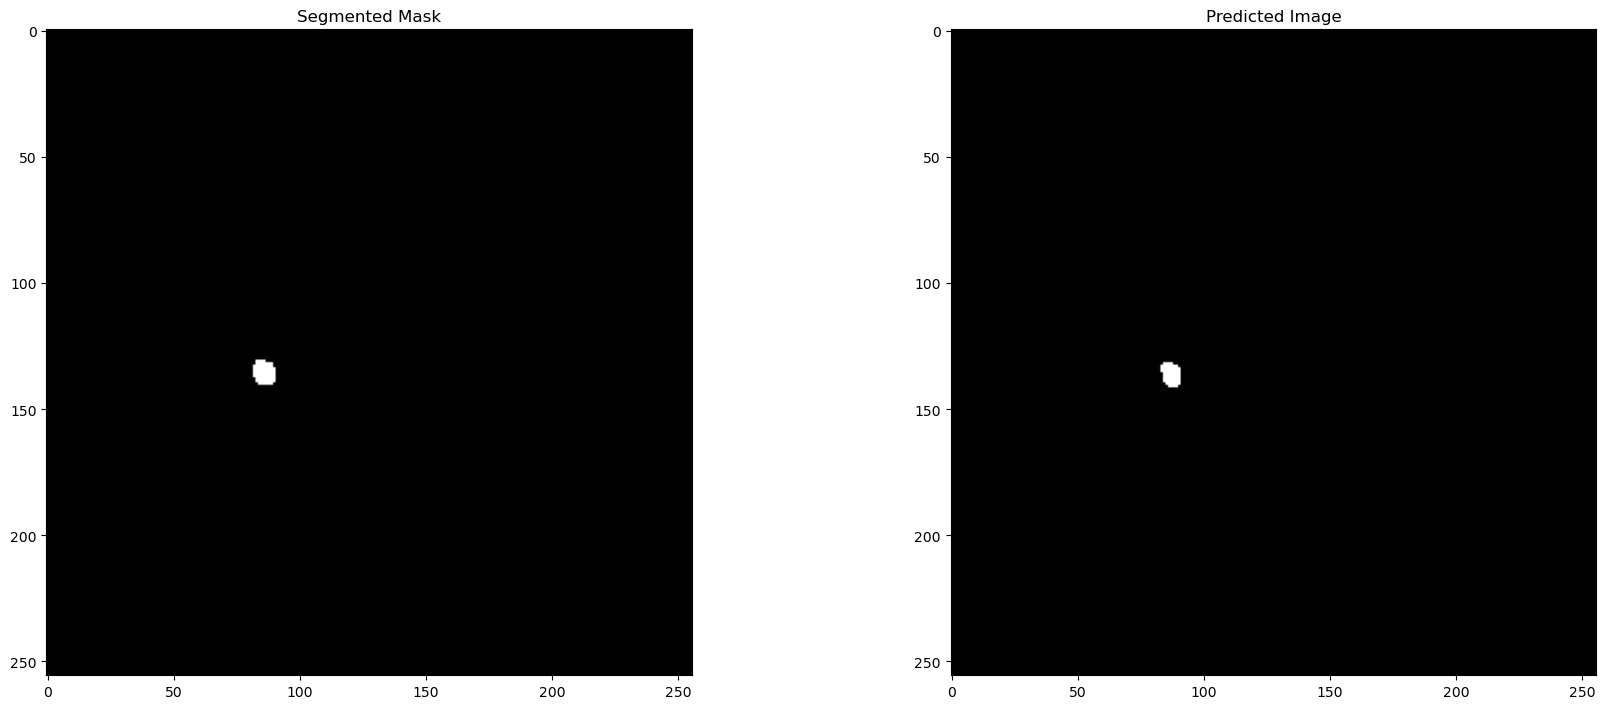

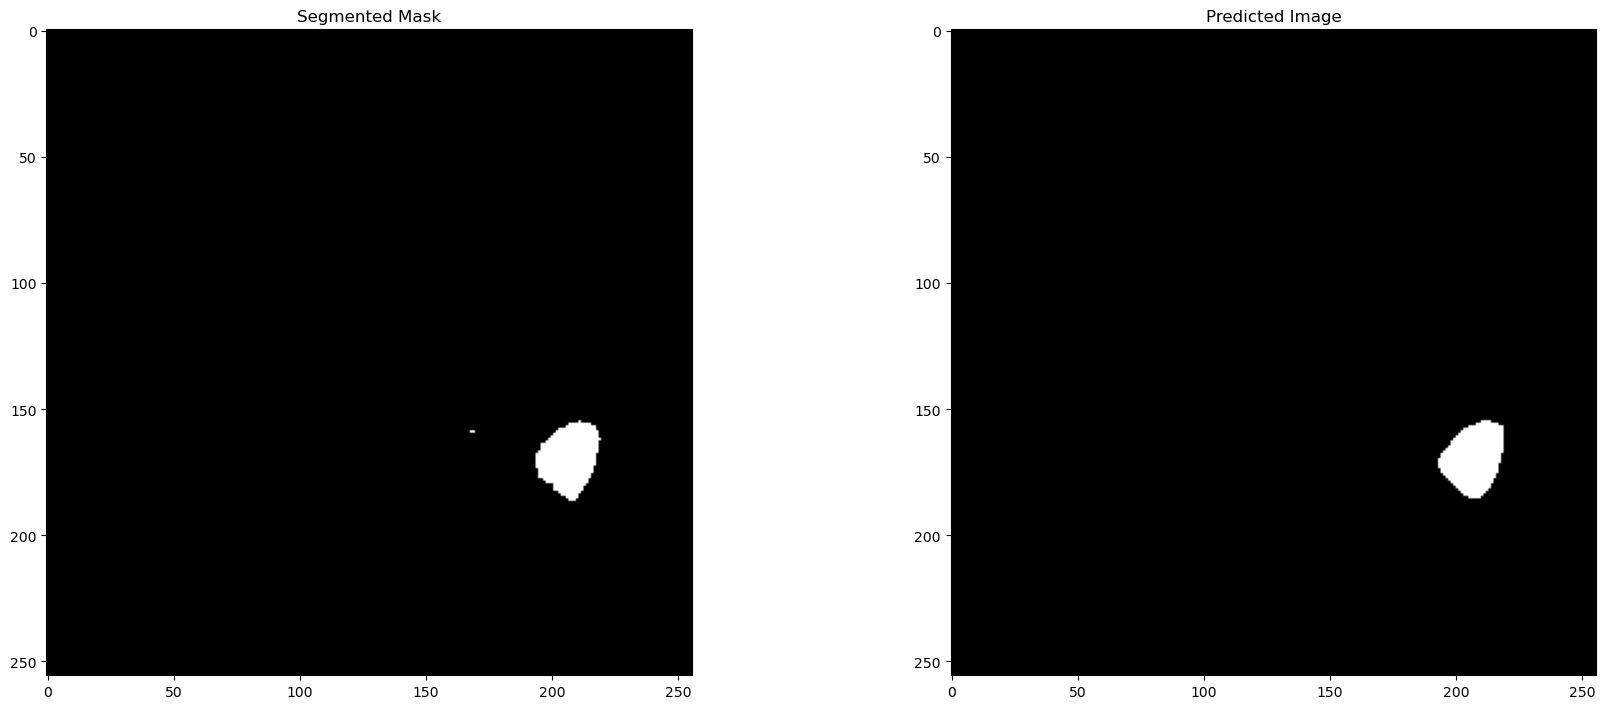

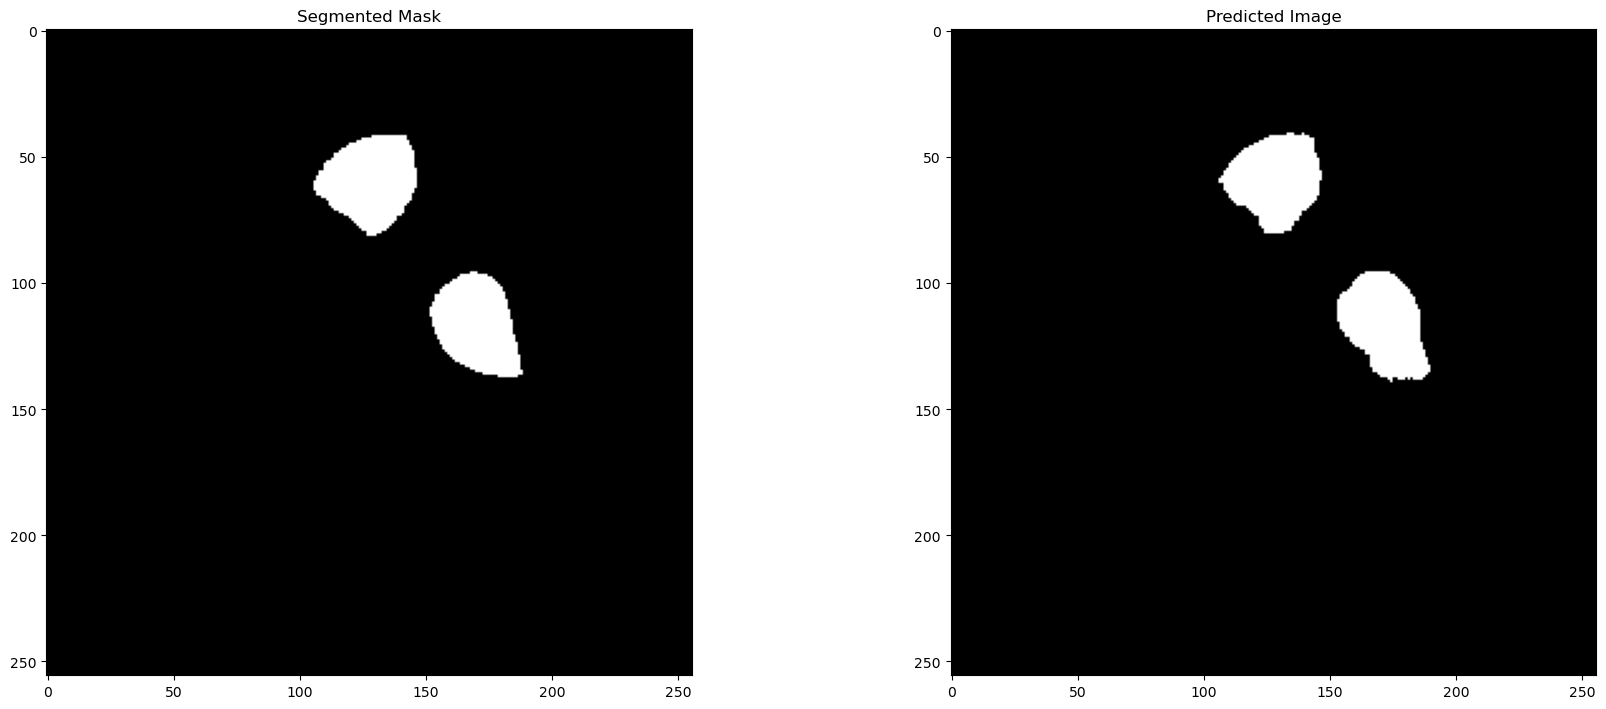

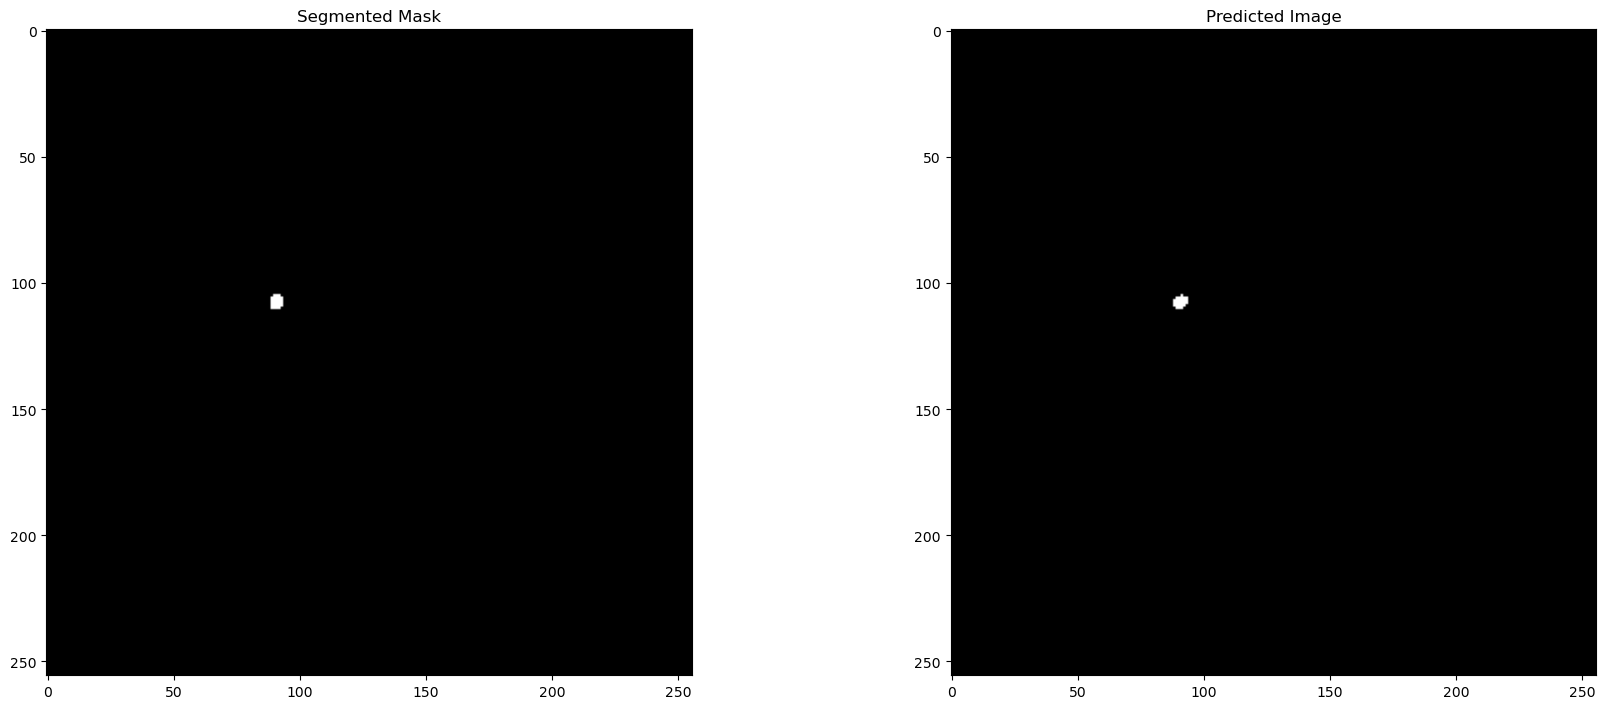

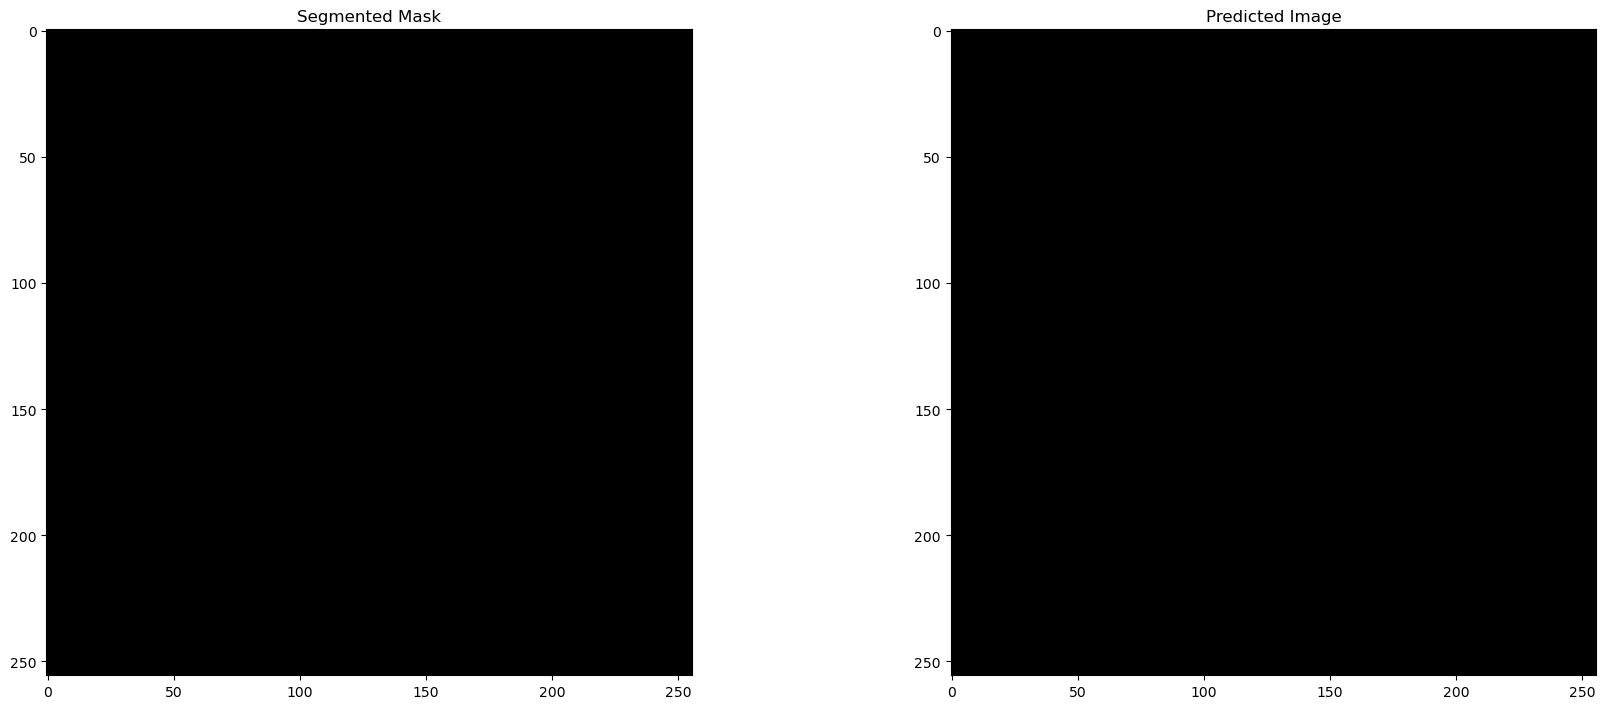

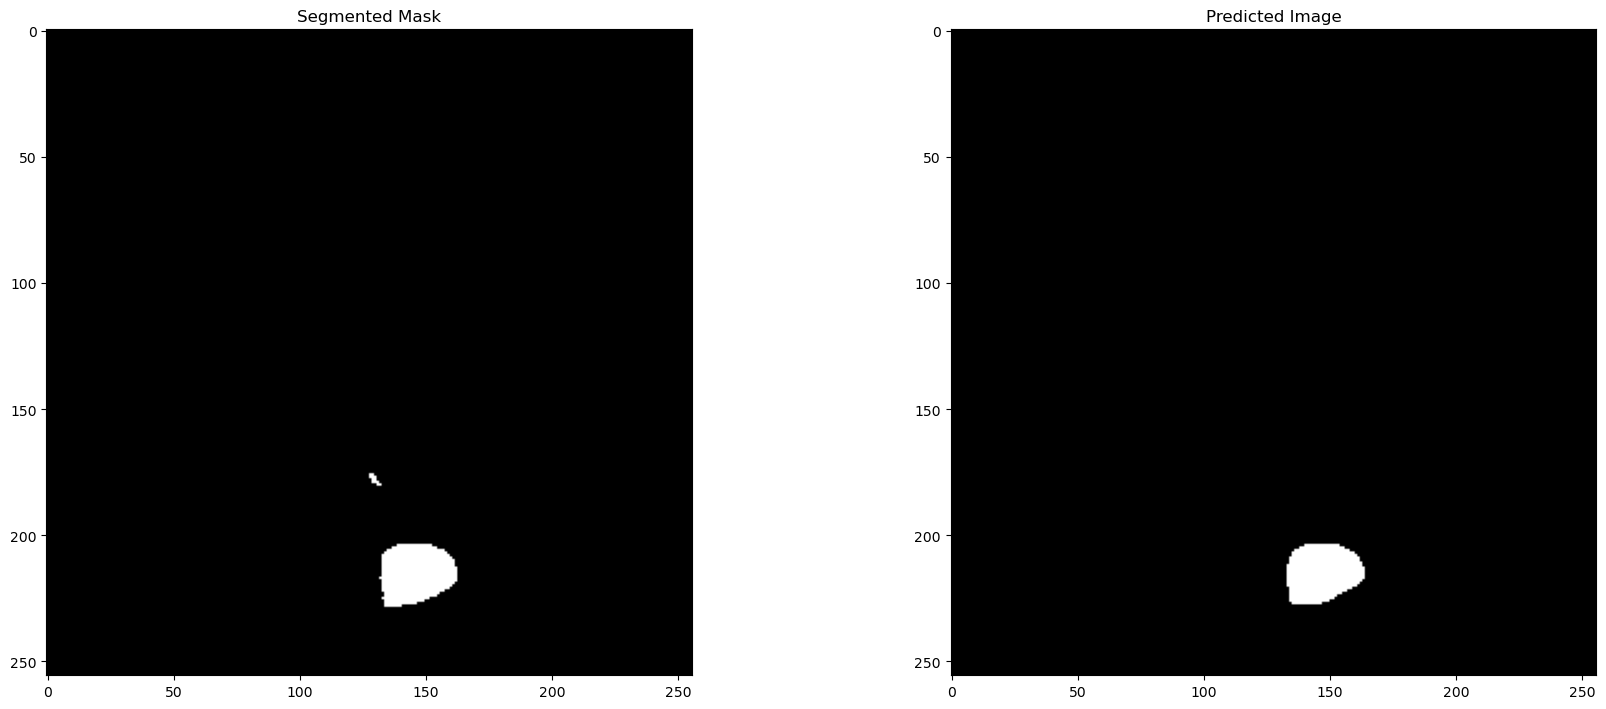

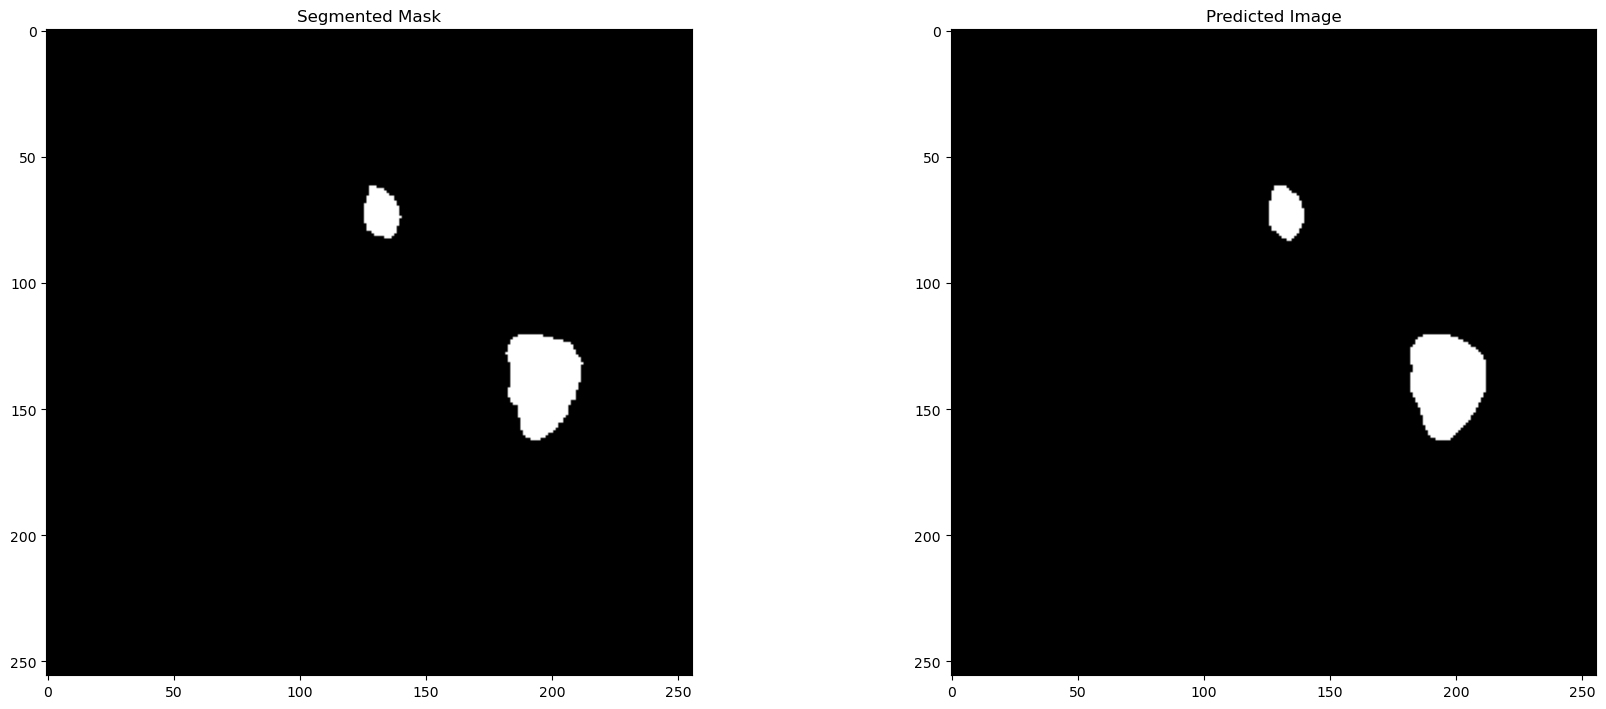

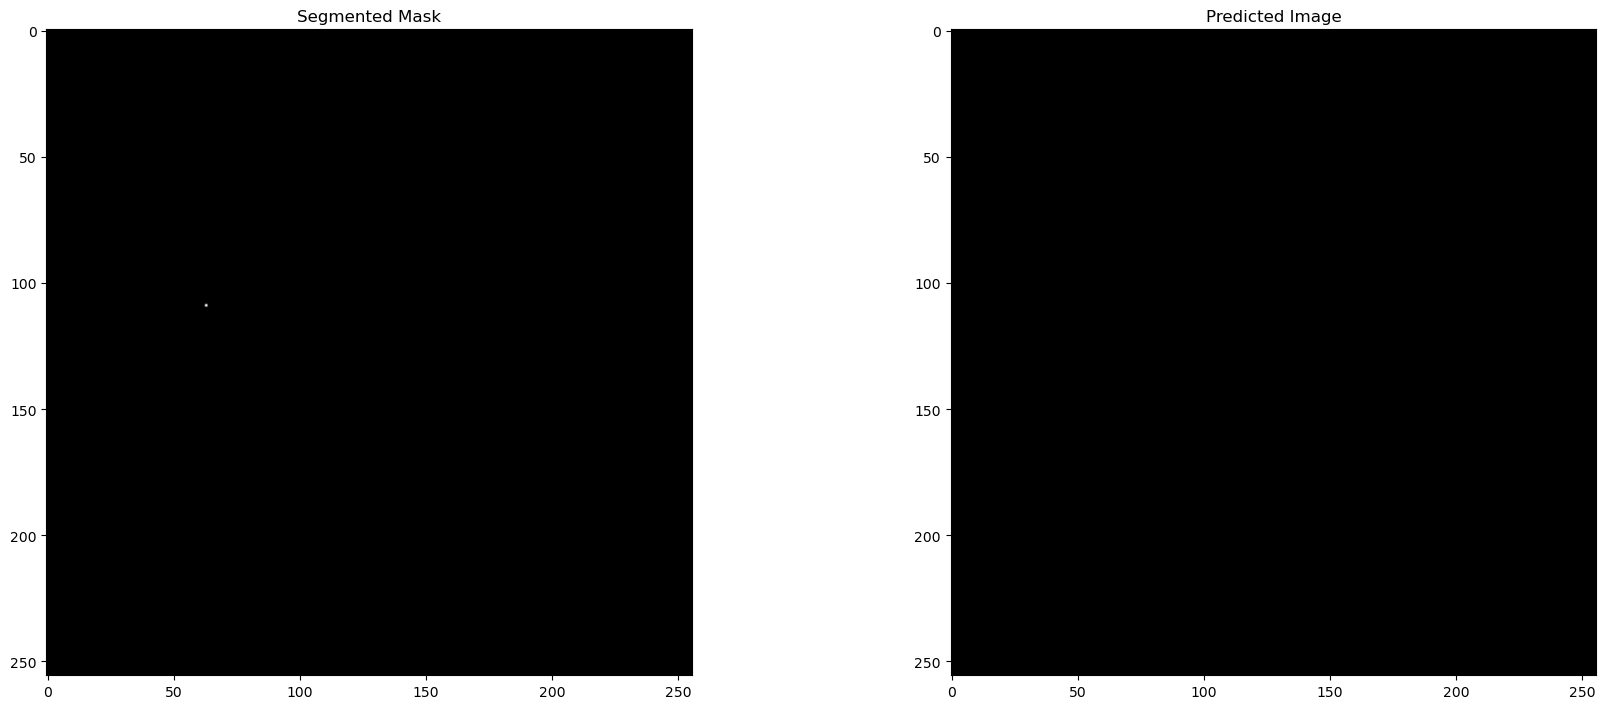

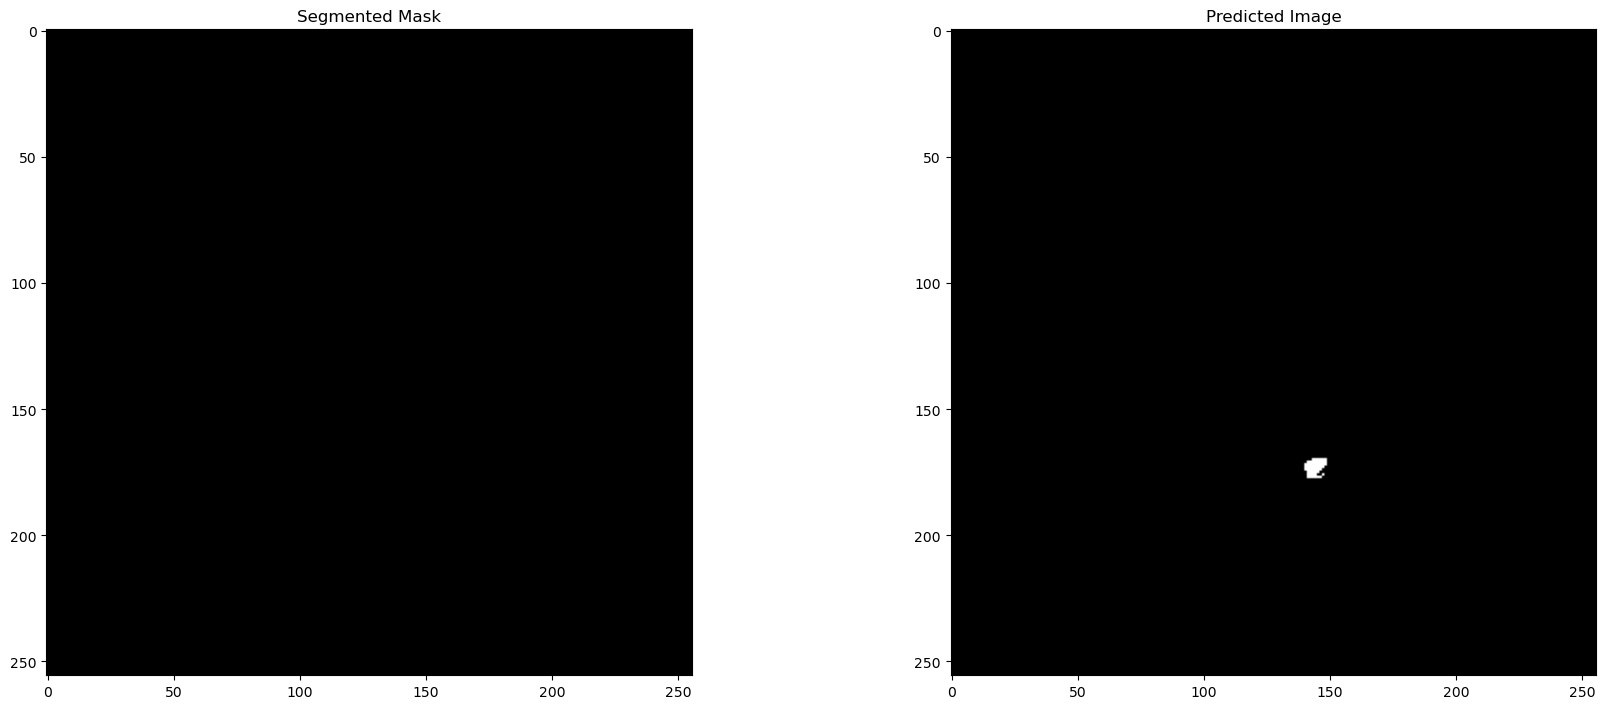

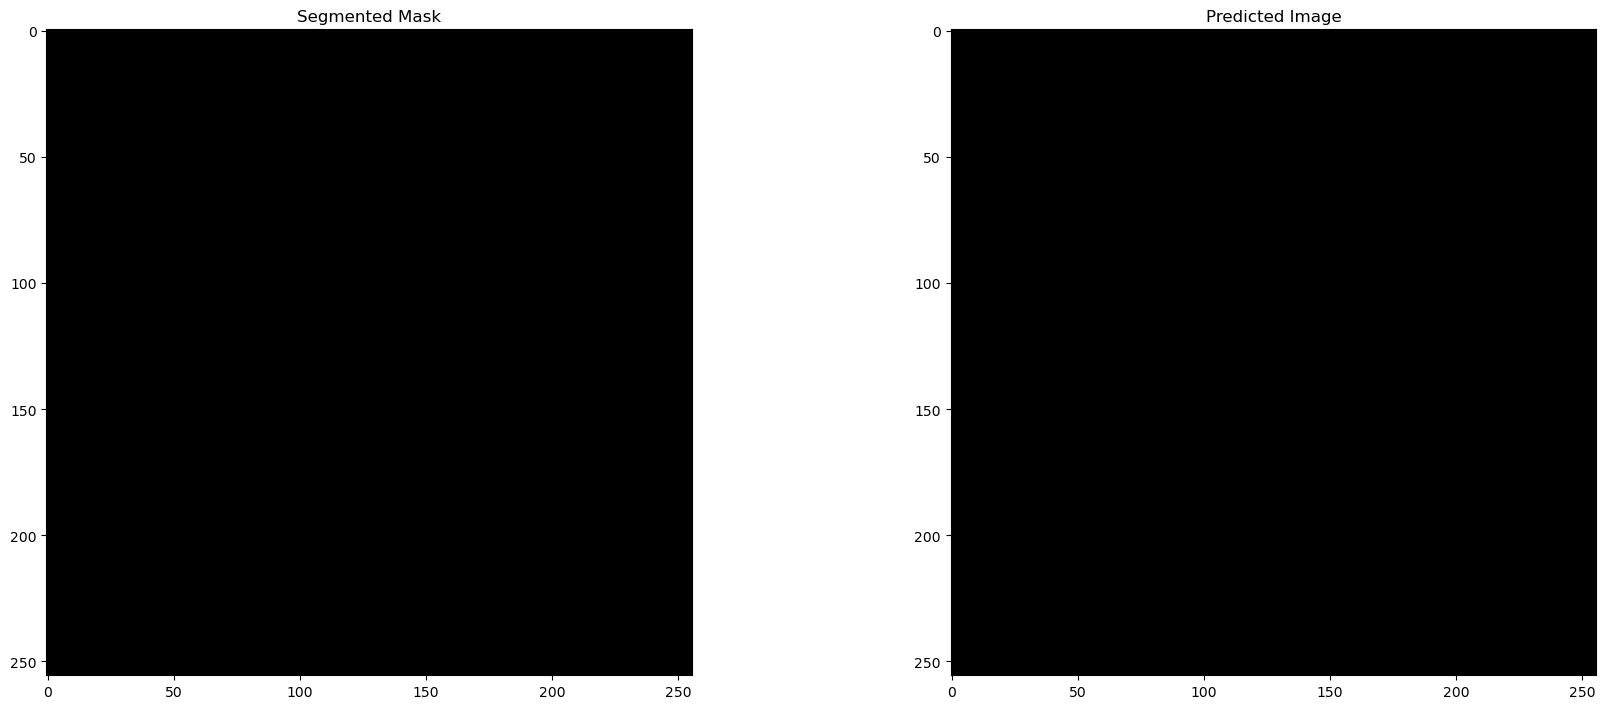

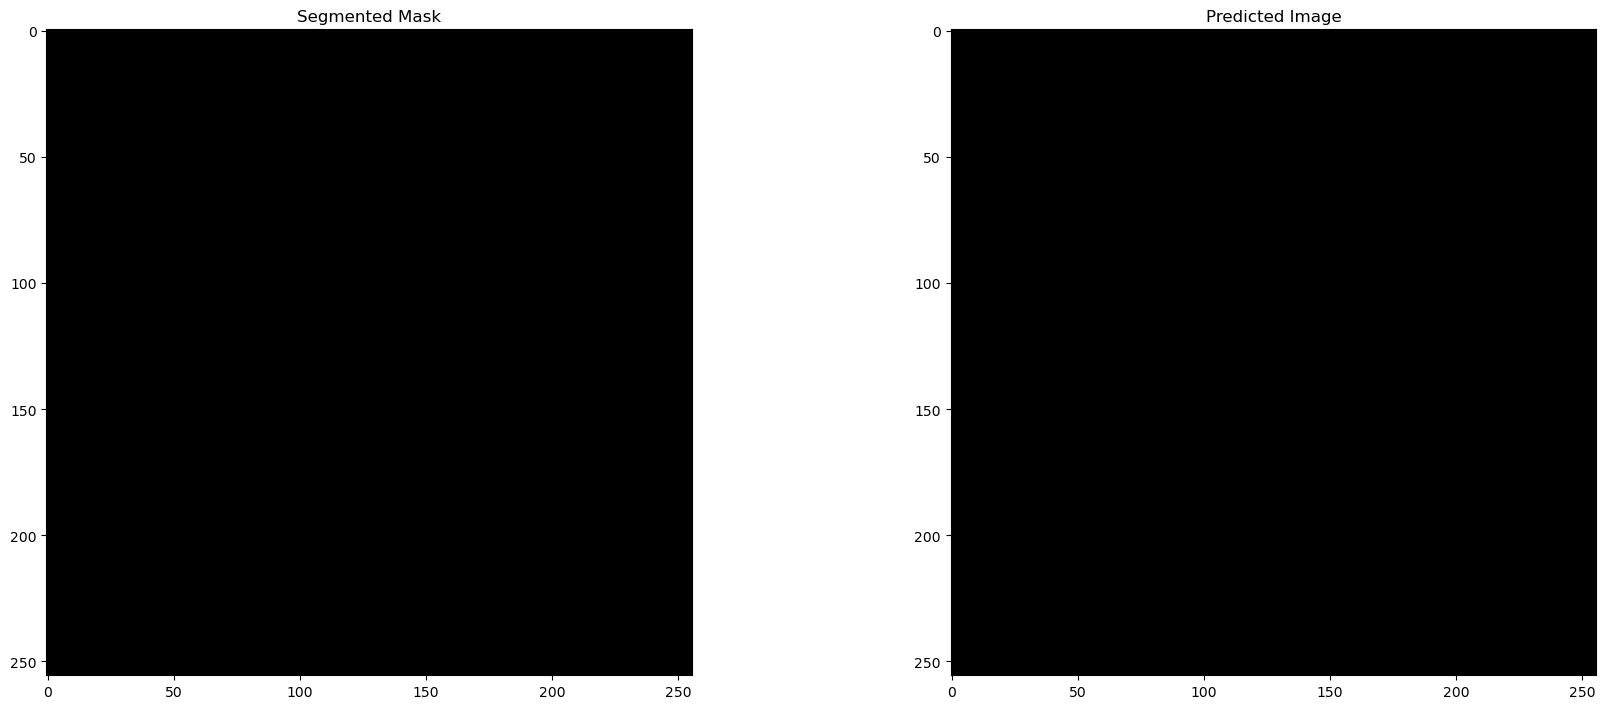

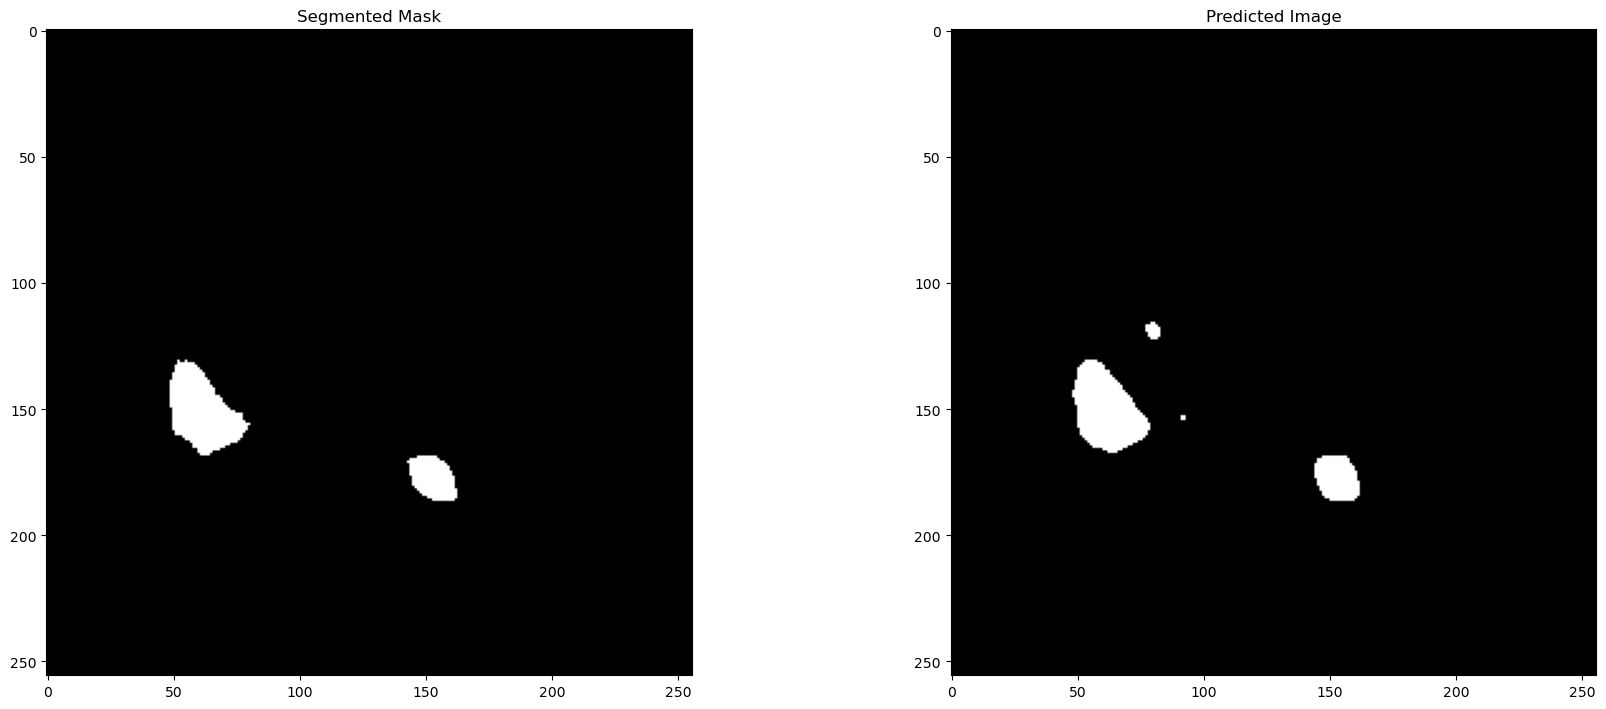

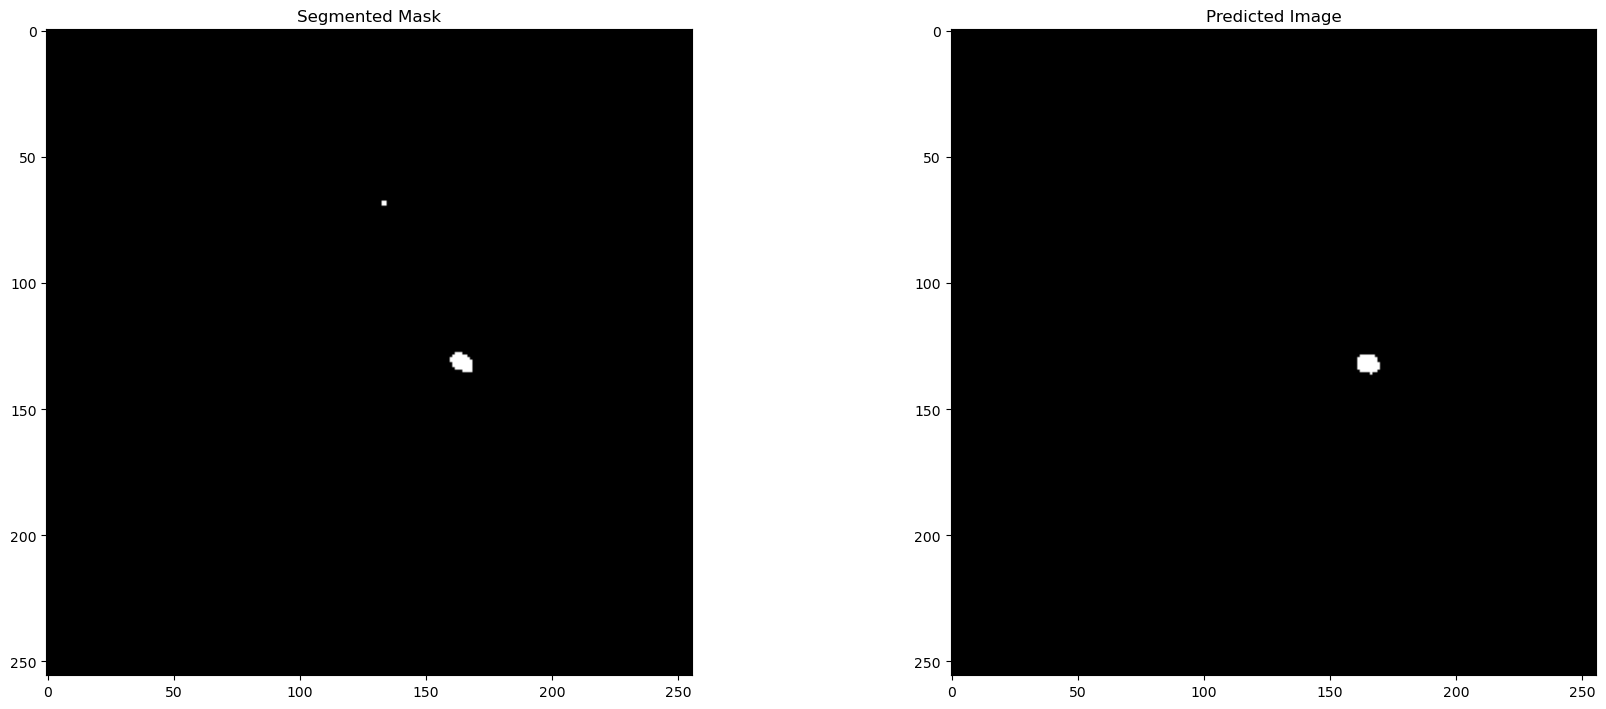

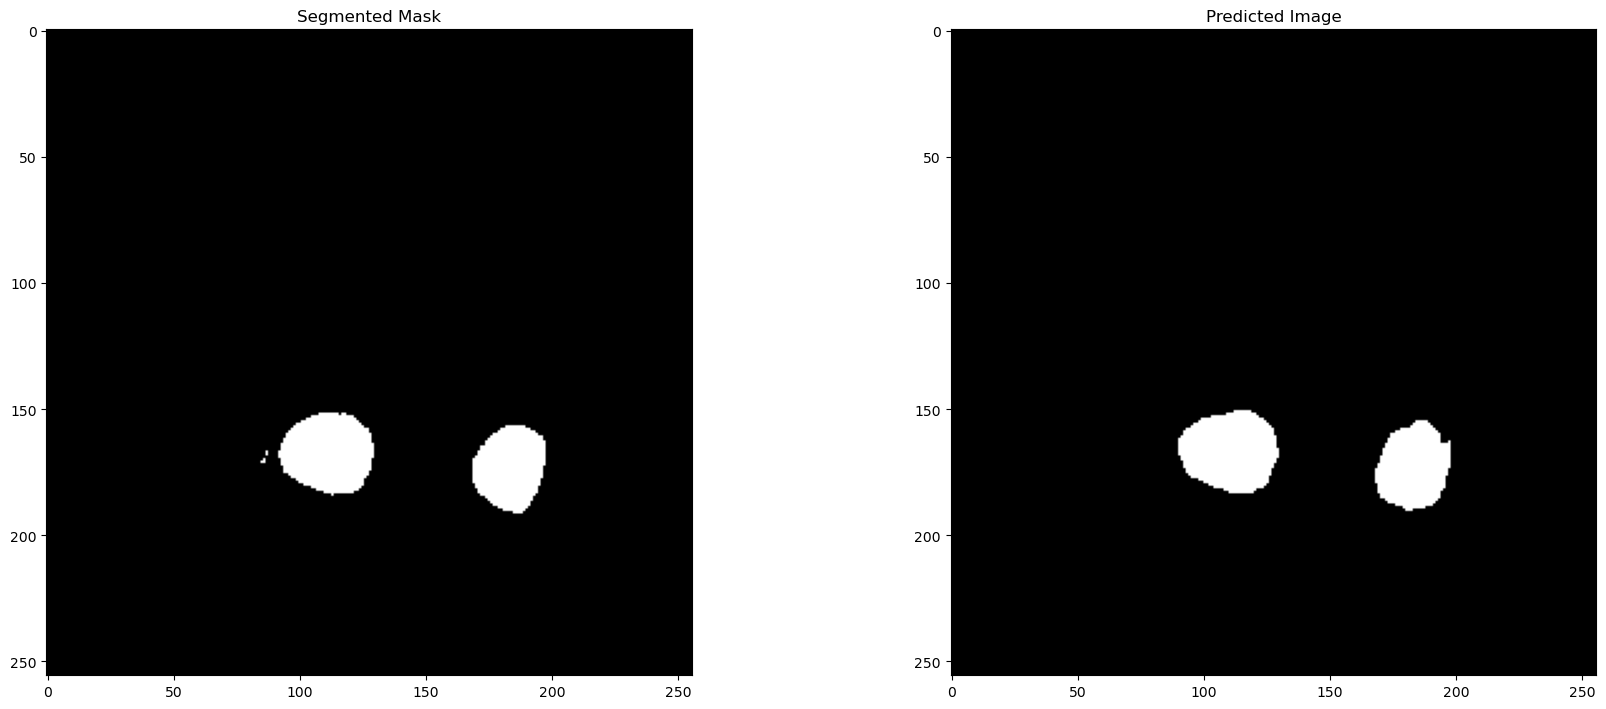

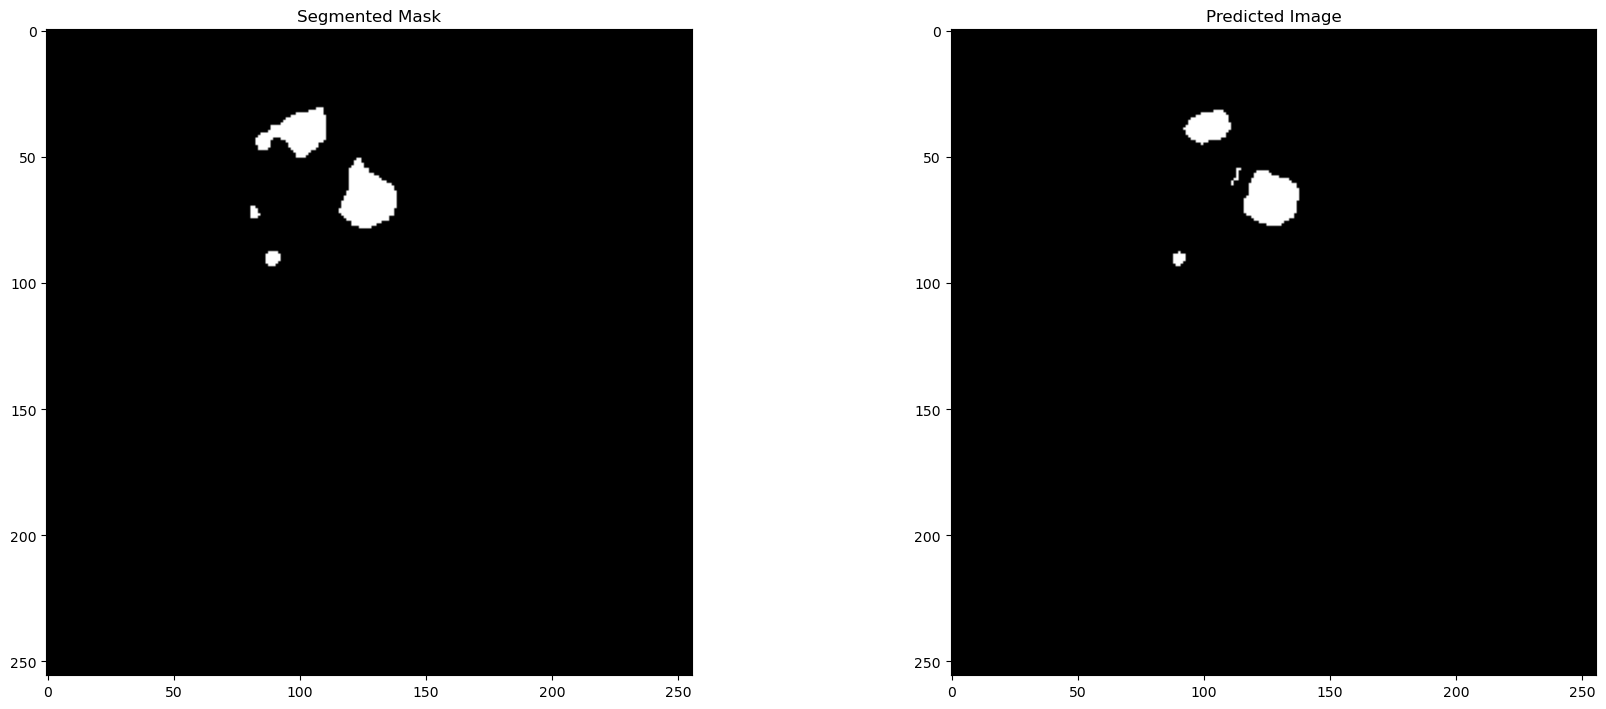

In [62]:
# imshow(np.reshape(y[2]*255, (image_size, image_size)), cmap="gray")
for i in range(1, 5, 1):
    ## Dataset for prediction
    x, y = valid_gen.__getitem__(i)
    result = model.predict(x)
    result = result > 0.5
#     print(id_name)
    for j in range(len(result)):
        fig = plt.figure(figsize=(20,20))
        fig.subplots_adjust(hspace=0.4, wspace=0.4)

        ax = fig.add_subplot(1, 2, 1)
        ax.imshow(np.reshape(y[j]*255, (image_size, image_size)), cmap="gray")
        ax.set_title("Segmented Mask")
#         ax.imshow(y[i])
        ax = fig.add_subplot(1, 2, 2)
        ax.imshow(np.reshape(result[j]*255, (image_size, image_size)), cmap="gray")
        ax.set_title("Predicted Image")

4
2
1/1 [==============================] - 0s 384ms/step


[[64994     2]
 [  157   383]]
[64994     2   157   383]


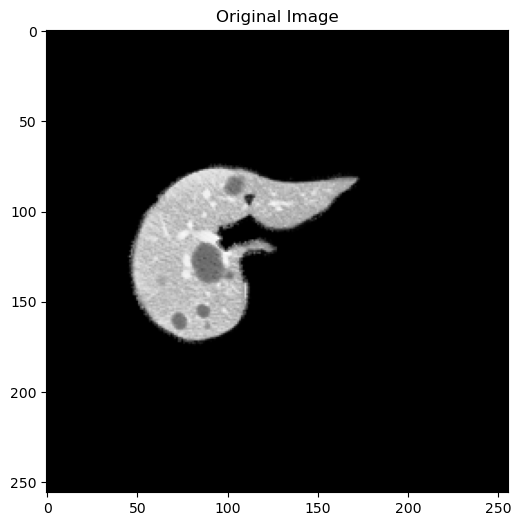

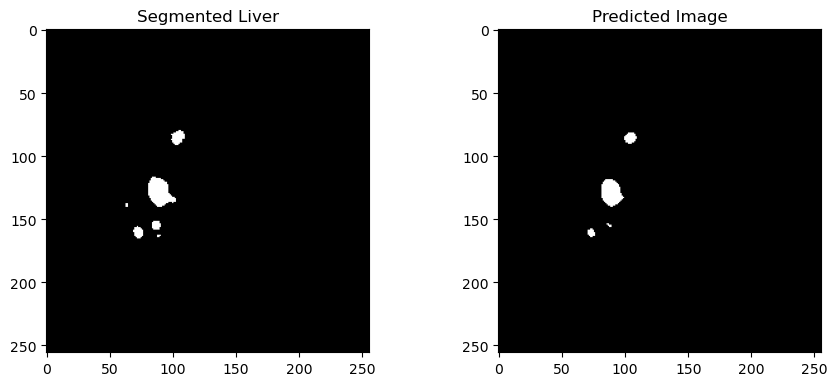

In [74]:
random_batch = random.randint(0, len(valid_ids)//batch_size - 1)
random_sample = random.randint(0, batch_size-1)
random_batch = 4
random_sample = 2
print(random_batch)
print(random_sample)
x, y = valid_gen.__getitem__(200)
result =  model.predict(x)
result = result > 0.9

fig2 = plt.figure(figsize=(6,6))
ax2 = fig2.add_subplot(1,1,1)
ax2.imshow(x[random_sample])
ax2.set_title("Original Image")

fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[random_sample]*255, (image_size, image_size)), cmap="gray")
ax.set_title("Segmented Liver")
# ax.imshow(y[i])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[random_sample]*255, (image_size, image_size)))
ax.set_title("Predicted Image")

# imshow(np.reshape(y[random_sample]*255, (image_size, image_size)), cmap="gray")
cm_2d = confusion_matrix(y[random_sample].flatten(), result[random_sample].flatten())
cm = cm_2d.ravel()

# (tn, fp, fn, tp)
print(cm_2d)
print(cm)

In [75]:
print("Pixel Accuracy " + str(((cm[3]+cm[0])/(cm[3]+cm[0]+cm[1]+cm[2])*100))+'%' )
print("True Positive Accuracy " + str(((cm[3])/(cm[3]+cm[2])*100))+'%' )
print("Dice Coefficient " + str((2*(cm[3])/(2*cm[3]+cm[2]+cm[1])*100))+'%' )

Pixel Accuracy 99.75738525390625%
True Positive Accuracy 70.92592592592592%
Dice Coefficient 82.8108108108108%


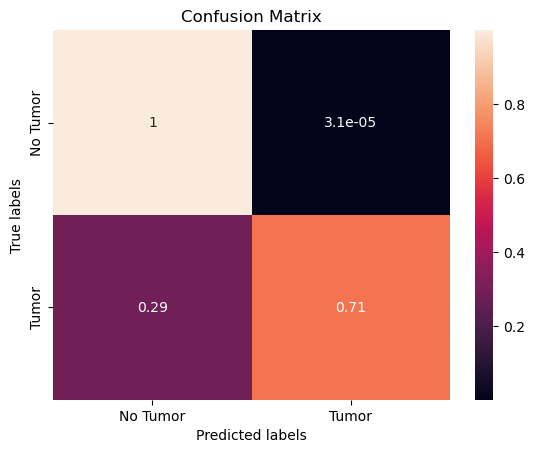

In [76]:
ax= plt.subplot()
cm_2d = cm_2d.astype('float') / cm_2d.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_2d, annot=True, ax = ax); #annot=True to annotate cells

# print(count_cms)
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Tumor', 'Tumor']); ax.yaxis.set_ticklabels(['No Tumor', 'Tumor']);



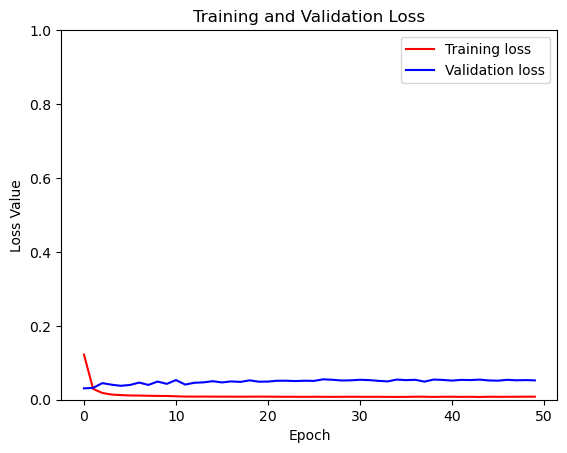

In [66]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

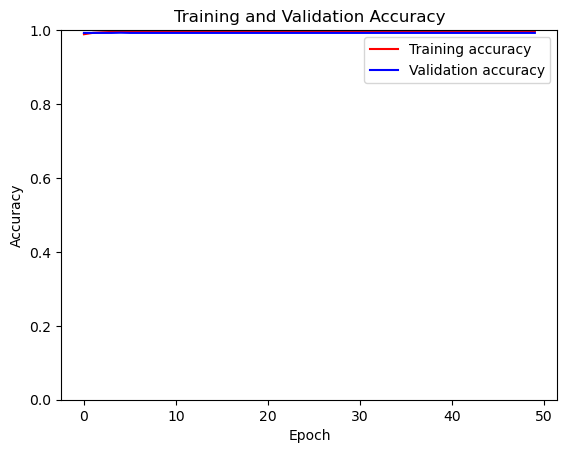

In [67]:
# Access training and validation accuracy values from the 'history' attribute
accuracy = model_history.history['acc']
val_accuracy = model_history.history['val_acc']

plt.figure()
plt.plot(range(len(accuracy)), accuracy, 'r', label='Training accuracy')
plt.plot(range(len(val_accuracy)), val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.show()
